# Audible Data Analysis

#### Data Scraped on 5/10/21

- [Introduction & Requirements](#intro)
- [Data Import](#import)
- [Data Preparation](#data_prep)
- [Library Growth](#library)
- [Time Series Investigation](#time_series)
- [Titles & Subtitles](#titles_sub)
- [Authors & Narrators](#auth_narr)
- [Author as Narrator](#auth_as_narr)
- [Languages](#lang)
- [Price](#price)
- [Length](#length)
- [Bang for your Buck](#bang4buck)
- [Reviews and Ratings](#reviews)
- [Categories](#categories)
- [Price vs Length](#price_length)
- [Translation as Service](#translation)
- [Audible Category Analysis](#cats)
- [EDA](#cat_eda)
- [Category Networks](#network)


### Introduction & Requirements <a id='intro'></a>
This notebook documents the data analysis of the title and category information scraped from Audible.com and Amazon.com. Generally we will focus on book length, price, ratings, and number of listens. 

Please run the web scraping programs below before analsis. Static images will be included in the presentation accompanying this notebook. **Confirm requirements.txt is met**:
- books_scrapy_audible -> category_spider
- books_scrapy_audible -> titles_spider

Running these programs should result in the following csv files
- books_scrapy_audible -> category_hierarchy_n_urls.csv
- books_scrapy_audible -> title_information.csv

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from statistics import mode
import networkx as nx
import matplotlib.pyplot as plt
import missingno

### Data Import <a id='import'></a>
Due to the nature of the scraping program, which you can read about in the README.md, most titles have been scraped multiple times. Luckily all urls lead to the same product and are unique so they can help us easily filter for unique titles, and categories can be condensed into a list which will act like a list of tags. 

In [2]:
cat_data   = pd.read_csv("books_scrapy_audible/category_hierarchy_n_urls.csv")
title_data = pd.read_csv("books_scrapy_audible/title_information.csv")

In [3]:
title_data.head()

,author,count_rating,language,length,narrator,pod_flag,price,release_date,star_rating,subtitle,title,title_category,title_url
0,Yuval Noah Harari,43059.0,English,917,Derek Perkins,False,34.22,08-15-17,4.5,A Brief History of Humankind,Sapiens,Biological Sciences,https://www.audible.com/pd/Sapiens-Audiobook/B...
1,Walter Isaacson,1622.0,English,964,"Kathe Mazur,Walter Isaacson",False,28.34,03-09-21,4.5,"Jennifer Doudna, Gene Editing, and the Future ...",The Code Breaker,Biological Sciences,https://www.audible.com/pd/The-Code-Breaker-Au...
2,James Nestor,4300.0,English,438,James Nestor,False,24.50,05-26-20,5.0,The New Science of a Lost Art,Breath,Biological Sciences,https://www.audible.com/pd/Breath-Audiobook/05...
3,Robin Wall Kimmerer,4346.0,English,1004,Robin Wall Kimmerer,False,34.99,12-27-15,5.0,"Indigenous Wisdom, Scientific Knowledge and th...",Braiding Sweetgrass,Biological Sciences,https://www.audible.com/pd/Braiding-Sweetgrass...
4,Suzanne Simard,5.0,English,733,Suzanne Simard,False,31.50,05-04-21,5.0,Discovering the Wisdom of the Forest,Finding the Mother Tree,Biological Sciences,https://www.audible.com/pd/Finding-the-Mother-...


In [3]:
cat_data.head()

,category_name,category_numb_title,leaf_flag,parent_category,parent_url,self_url,title_list_url
0,Travel & Tourism,8631,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Travel-Tourism-Aud...,https://www.audible.com/search?node=1858109501...
1,Teen,18661,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Teen-Audiobooks/18...,https://www.audible.com/search?node=1858071501...
2,Sports & Outdoors,22415,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Sports-Outdoors-Au...,https://www.audible.com/search?node=1858064801...
3,Science Fiction & Fantasy,61202,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Fiction-Fa...,https://www.audible.com/search?node=1858060601...
4,Science & Engineering,17495,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Engineerin...,https://www.audible.com/search?node=1858054001...


# Data Preparation <a id='data_prep'></a>

#### Cleaning Duplicates and Filtering Podcasts
Since Audible treats categories more like tags, most titles belonging to multiple, there is a significant number of duplicated titles and information. 


Podcasts are also present in our data, which I didn't know Audible offered, but since they are not the focus of the scraping they are discarded. 

Number of titles scraped:  622065
Number of unique titles (books+pods):  286200
Unique Podcasts:  6959
Unique Books:  279241


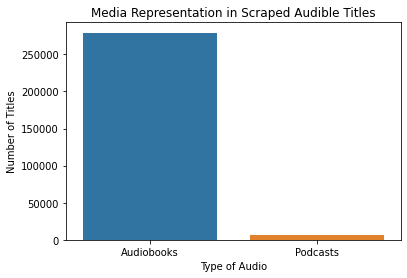

In [4]:
print("Number of titles scraped: ", len(title_data.title_url) )
print("Number of unique titles (books+pods): ", len(np.unique(title_data.title_url)))
print("Unique Podcasts: ",len(np.unique(title_data.title_url[title_data.pod_flag == True])))
print("Unique Books: ",len(np.unique(title_data.title_url[title_data.pod_flag == False])))

data = np.where(title_data.drop_duplicates(subset = ['title_url'])['pod_flag'] == True, "Podcasts", "Audiobooks" )
sns.countplot(x=data).set(xlabel="Type of Audio", ylabel = "Number of Titles")

plt.title("Media Representation in Scraped Audible Titles")

plt.savefig("./graphics/media_types.png", bbox_inches = 'tight')

In [6]:
# Remove podcasts from dataframe
title_data = title_data.loc[title_data.pod_flag == False]
# Dropping a mis-formated podcast
title_data = title_data.loc[title_data.title != 'Wälder News']

Due to titles appearing in multiple categories, other fields were effected which were cleaned in the following manner.
- **title_category**: collapsed into a list.
- **count_rating**: max value retained.  
- **star_rating**: max value retained.
- **release_date**: max value retained. I believe this is due to reuploading into a new category.
- **length**: max value retained. I believe this is due to reuploading into a new category.
- **category_number**: New Column, number of categories a title was scraped in.

In [7]:
titles = title_data.groupby('title_url', dropna = False).agg({
                                              'author'        :mode,
                                              'language'      :mode,
                                              'narrator'      :mode,
                                              'pod_flag'      :mode,
                                              'price'         :mode,
                                              'subtitle'      :mode,
                                              'title'         :mode,
                                              'release_date'  :'max',
                                              'length'        :'max',
                                              'star_rating'   :'max', 
                                              'count_rating'  :'max',
                                              'title_category': lambda x: list(x)}
                                            ).reset_index()




"This leaves {} books remaining, compared to the +200,000 reported publically by Audible".format(len(np.unique(titles.title_url)))

'This leaves 279240 books remaining, compared to the +200,000 reported publically by Audible'

#### Filling missing values and adding new columns for later use.
Most code chunks will also derive the column in case chunks are run out of order. 

In [8]:
titles.drop('pod_flag', axis =1)

titles['subtitle']      = titles['subtitle'].replace(np.nan, "")
titles['count_rating']  = titles['count_rating'].fillna(0)

titles['category_number'] = titles['title_category'].str.len()

titles['author']        = [x.split(',') for x in titles.author.replace(np.nan,"")]
titles['narrator']      = [x.split(',') for x in titles.narrator.replace(np.nan,"")]

titles['pub_datetime']  = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

titles['language']      = titles['language'].str.replace("_"," ").str.title()

titles['star_rating']   = titles['star_rating'].astype('string').replace(np.nan,"")

# 54 books had prices missing, droping to make life easier.
titles = titles[titles.price.notnull()]

In [9]:
import missingno as msno

#no missing values

#msno.matrix(titles)
#msno.heatmap(titles)

# Library Growth <a id='library'></a>

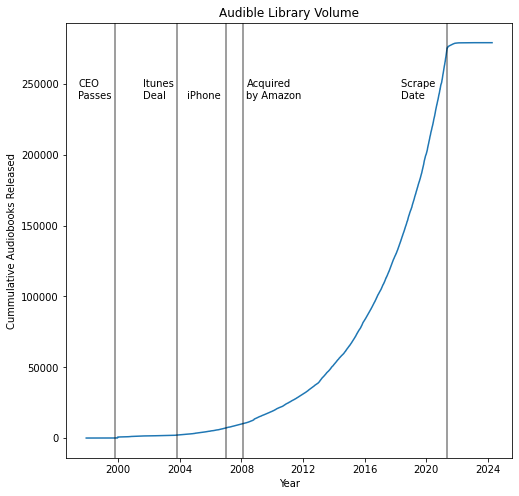

In [74]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_pub'] = titles.sort_values('pub_datetime', ascending = True).reset_index().index

plt.rcParams['figure.figsize'] = (8,8)

plot = sns.lineplot( 
             x   = titles.pub_datetime.sort_values(), 
             y   = titles.reset_index().index,
             ci  = None)

plt.title("Audible Library Volume")
plot.set_xlabel("Year")
plot.set_ylabel("Cummulative Audiobooks Released")

# CEO Passed
plot.axvline(x=pd.to_datetime("1999-10-24"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("1997-05-24"),240000, "CEO\nPasses", color ='k')

# Exclsive provider of audiobooks for itunes
plot.axvline(x=pd.to_datetime("2003-10-16"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2001-08-16"),240000, "Itunes\nDeal", color ='k')

# iphone released
plot.axvline(x=pd.to_datetime("2007-01-09"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2004-06-09"),240000, "iPhone", color ='k')

# amazon purchase
plot.axvline(x=pd.to_datetime("2008-01-31"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2008-04-30"),240000, "Acquired\nby Amazon", color ='k')

# Scrape Date 
plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/library_timeseries.png", bbox_inches = 'tight')

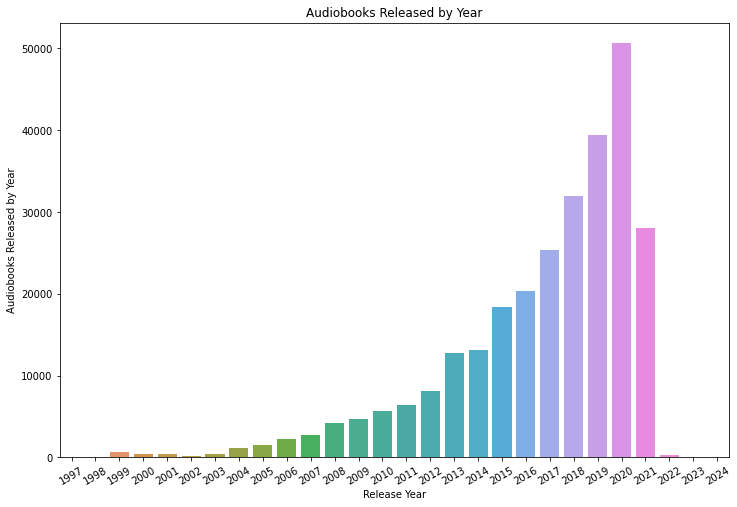

In [124]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
years = pd.DatetimeIndex(titles.pub_datetime).year

plt.rcParams['figure.figsize'] = (12,8)

plot = sns.countplot(x = years)

plot.set_xticklabels(range(1997,2025))

plt.title("Audiobooks Released by Year")
plot.set_xlabel("Release Year")
plt.xticks(rotation =30)
plot.set_ylabel("Audiobooks Released by Year")

plt.savefig("./graphics/lang_timeseries_box.png", bbox_inches = 'tight')

<ipython-input-8-68cb100371ca>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


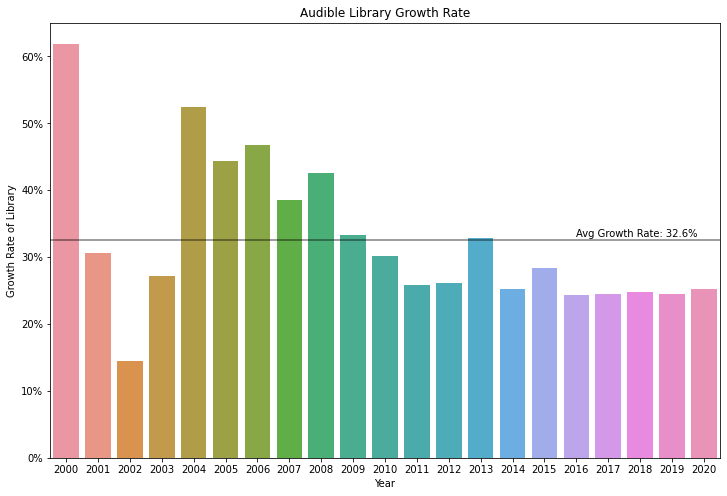

In [8]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
years = pd.DatetimeIndex(titles.pub_datetime).year
years = years.value_counts().sort_index().drop(labels = [2021,2022,2023,2024])
years = np.cumsum(years)

diff_y = years.diff().drop(labels = [1997])
years = years.drop(labels = [2020])


perc_change = pd.Series([(x/y)*100 for x, y in list(zip(diff_y, years))],index = diff_y.index)
perc_change = perc_change.drop(labels = [1998,1999])

plt.rcParams['figure.figsize'] = (12,8)

plot = sns.barplot(x=perc_change.index, y =perc_change)

plot.axhline(y= np.mean(perc_change), xmin=0, xmax=1, color = 'k',alpha = 0.5)
plot.text(16,33, "Avg Growth Rate: {:.1f}%".format(np.mean(perc_change)), color ='k')

yticks = [str(x)+"%" for x in range(0,70,10)]
plot.set_yticklabels(yticks)

plt.title("Audible Library Growth Rate")
plot.set_xlabel("Year")
plot.set_ylabel("Growth Rate of Library")

plt.savefig("./graphics/growth_rate.png", bbox_inches = 'tight')

# Time Series Investigation <a id='time_series'></a>

Yes, I think this is the wrong graph type, open to suggestions.

The only time to variable correlations seem to be category number and star rating.

Category Number:
- I think this is best explained by Audibles categories-as-tags system; Older audiobooks have collected more tags.

Star Rating:
- This is likely recency bias, more recent books are more likely to have been listened to by people excited or interested in them. 

<AxesSubplot:xlabel='pub_datetime', ylabel='category_number'>

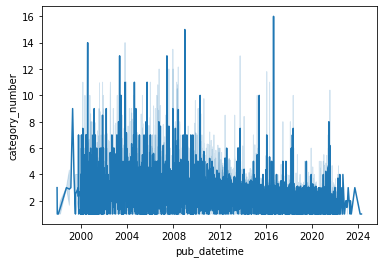

In [148]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.category_number,err_style='band')

<AxesSubplot:xlabel='pub_datetime', ylabel='length'>

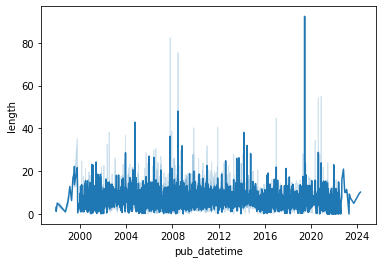

In [136]:
sns.lineplot(x=titles.pub_datetime,
             y=(titles.length/60) )

<AxesSubplot:xlabel='pub_datetime', ylabel='price'>

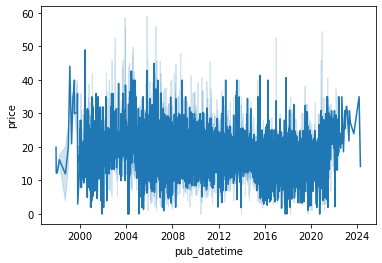

In [149]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.price )

<AxesSubplot:xlabel='pub_datetime', ylabel='count_rating'>

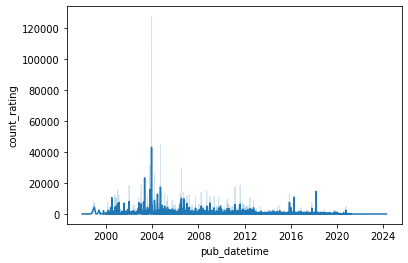

In [150]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.count_rating )

<AxesSubplot:xlabel='pub_datetime', ylabel='star_rating'>

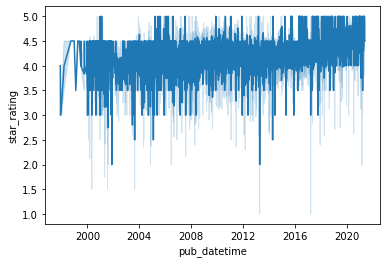

In [153]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.star_rating.replace("",np.nan).astype(float) )

<AxesSubplot:xlabel='pub_datetime', ylabel='star_rating'>

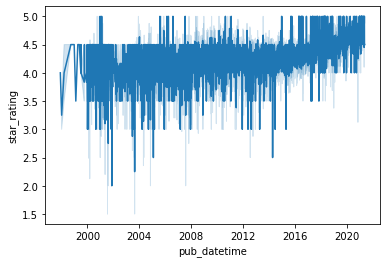

In [159]:
# examining stars again but only titles with more than 4 reviews.
sns.lineplot(x = titles[titles.count_rating>4]['pub_datetime'],
            y = titles[titles.count_rating>4]['star_rating'].astype(float))

# Titles and Subtitles <a id='titles_sub'></a>

Subtitle       168614
No Subtitle    110687
Name: subtitle, dtype: int64
279301


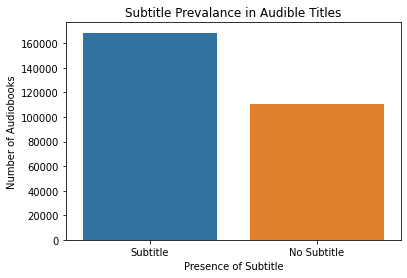

In [109]:
data = (titles['subtitle'] != "").replace({True:"Subtitle",False:"No Subtitle"})
plot = sns.countplot(x=data)

plot.set_xlabel("Presence of Subtitle") 
plot.set_ylabel("Number of Audiobooks")

plt.title("Subtitle Prevalance in Audible Titles")

plt.savefig("./graphics/sub-title_count.png", bbox_inches = 'tight')
print(data.value_counts())
print(len(data))

Percent with Subtitles: 60.4%
Median title length: 4.0
Mode title length: 0    3
dtype: int64
Median subtitle length: 4.0
Mode subtitle length: 0    0
dtype: int64
Median subtitle length (non-zero): 6.0
Mode subtitle length (non-zero): 0    5
dtype: int64


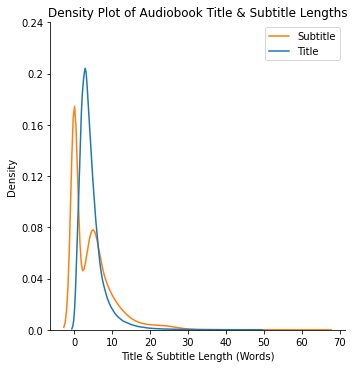

In [112]:
sub_data_word = titles.subtitle.str.split().str.len()
title_data_word = titles.title.str.split().str.len()

data = pd.concat([title_data_word,sub_data_word], axis=1).stack().reset_index()
data.columns = ['Index','Feature','Length']
data['Feature'] = data['Feature'].str.title()

plot = sns.displot(data = data, x = 'Length',kind = 'kde', legend= False, hue = 'Feature',bw_adjust = 2)

plt.legend(["Subtitle","Title"])
plot.set_axis_labels("Title & Subtitle Length (Words)")
plt.title("Density Plot of Audiobook Title & Subtitle Lengths")


yticks = [x/200 for x in range(0,25,4)]
ylabels = [x*2 for x in yticks]
plt.yticks(yticks, ylabels)

plt.savefig("./graphics/title_subtitle_word_hist.png", bbox_inches = 'tight')

print("Percent with Subtitles: {:.1f}%".format(np.mean(sub_data_word != 0)*100))
print("Median title length: {}".format(title_data_word.median()))
print("Mode title length: {}".format(title_data_word.mode()))
print("Median subtitle length: {}".format(sub_data_word.median()))
print("Mode subtitle length: {}".format(sub_data_word.mode()))
print("Median subtitle length (non-zero): {}".format(sub_data_word[sub_data_word !=0].median()))
print("Mode subtitle length (non-zero): {}".format(sub_data_word[sub_data_word !=0].mode()))

#### Longest Titles

In [81]:
#pd.set_option('display.max_colwidth', None)
titles['title_length'] = titles.title.str.split().str.len() 
titles.sort_values('title_length', ascending = False).head(3)#['title_url'][0:3]

# weirdly the counts are the same?
# similar release date

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,title_length
93714,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Tailandia: Tips ese...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-17-20,60,5.0,200.0,[Asia],1,2020-01-17,3837,48
93715,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Tailandia: Tips ese...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-14-20,61,5.0,200.0,"[Adventure Travel, Asia]",2,2020-01-14,3817,46
93713,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Alemania: Tips esen...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-14-20,62,5.0,200.0,[Europe],1,2020-01-14,3819,44


#### Longest Subtitles

In [83]:
#pd.set_option('display.max_colwidth', None)

titles['subtitle_length'] = titles.subtitle.str.split().str.len() 
titles.sort_values('subtitle_length', ascending = False).head(3)#['title_url'][0:3]


,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,title_length,subtitle_length
71583,[Dr. Stanley Leary],Spanish,[Gonzalo Abad Cortes],False,19.95,"La Guia Definitiva Para La Felicidad, Aumentar...",Inteligencia Emotional (Emotional Intelligence),https://www.audible.com/pd/Inteligencia-Emotio...,05-29-20,410,5.0,3.0,[Stress Management],1,2020-05-29,4519,4,65
256357,"[The Cosmovisioners, Carlos Augusto Miguel Gue...",Spanish,[Dinorah Pena-Duran],False,14.95,Guía simple e intuitiva para aprender la lectu...,Tarot Para Principiantes [Tarot for Beginners],https://www.audible.com/pd/Tarot-Para-Principi...,03-17-21,246,5.0,25.0,[Divination],1,2021-03-17,6553,6,63
239809,[Sharon McKinsey],Spanish,[Maria],False,19.95,Comprender la Teoría de los Estilos de Relació...,Trastorno de Apego [Attachment Theory],https://www.audible.com/pd/Trastorno-de-Apego-...,03-12-21,338,5.0,50.0,"[Codependency, Self-Esteem]",2,2021-03-12,6525,5,62


# Authors and Narrators <a id='auth_narr'></a>

In [121]:
titles_authors = titles.explode('author')
titles_narrators = titles.explode('narrator')


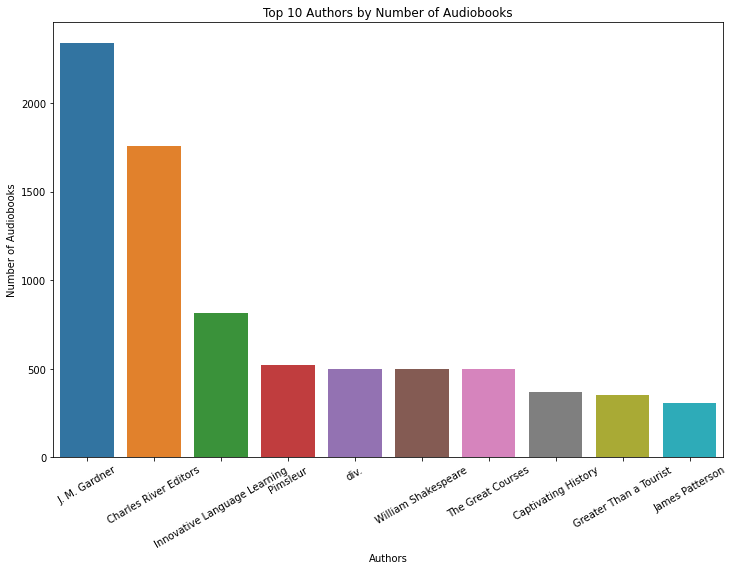

In [122]:
data = titles_authors.author.value_counts(ascending=False)[0:10]

plot = sns.barplot(x=data.index, y = data.values)

plt.xticks(rotation = 30)
plt.xlabel("Authors")
plt.ylabel("Number of Audiobooks")
plt.title("Top 10 Authors by Number of Audiobooks")

plt.savefig("./graphics/prolific_authors.png", bbox_inches = 'tight')

0    1
dtype: int64
1.0
2.515967601285264


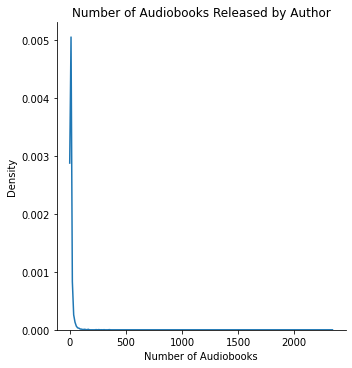

In [123]:
data = titles_authors.author.value_counts(ascending=False)

plot = sns.displot(x=data, kind = 'kde')

plt.xlabel("Number of Audiobooks")
plt.title("Number of Audiobooks Released by Author")

plt.savefig("./graphics/prolific_authors_dist.png", bbox_inches = 'tight')
print(data.mode())
print(data.median())
print(data.mean())

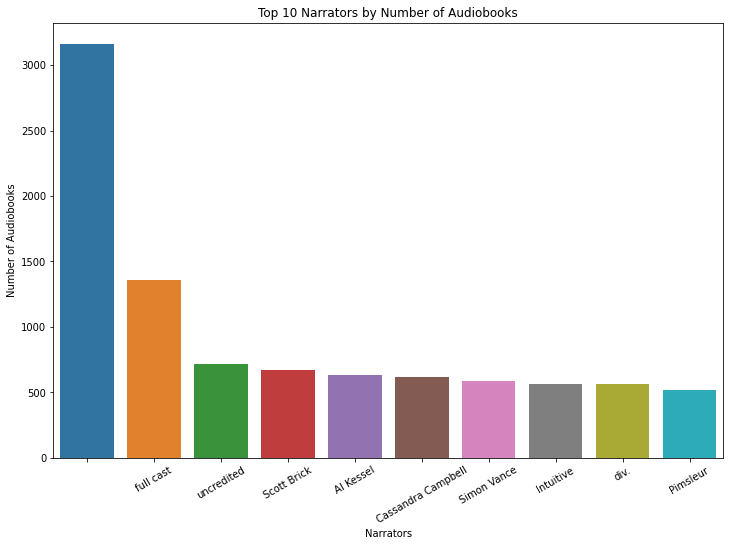

In [124]:
data = titles_narrators.narrator.value_counts(ascending=False)[0:10]

plot = sns.barplot(x=data.index, y = data.values)

plt.xticks(rotation = 30)
plt.xlabel("Narrators")
plt.ylabel("Number of Audiobooks")
plt.title("Top 10 Narrators by Number of Audiobooks")

plt.savefig("./graphics/prolific_narrators.png", bbox_inches = 'tight')

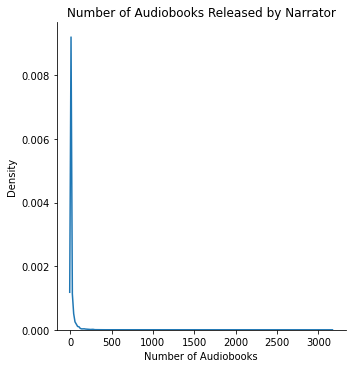

In [125]:
data = titles_narrators.narrator.value_counts(ascending=False)

plot = sns.displot(x=data, kind = 'kde')

plt.xlabel("Number of Audiobooks")
plt.title("Number of Audiobooks Released by Narrator")

plt.savefig("./graphics/prolific_narrators_dist.png", bbox_inches = 'tight')

0    1
dtype: int64
1.0
4.829688213796254
0    2
dtype: int64


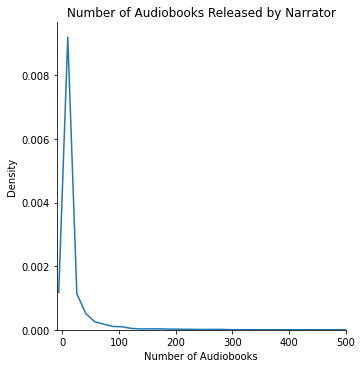

In [91]:
data = titles_narrators.narrator.value_counts(ascending=False)

plot = sns.displot(x=data, kind = 'kde')

plt.xlim(-10,500)
plt.xlabel("Number of Audiobooks")
plt.title("Number of Audiobooks Released by Narrator")

#plt.savefig("./graphics/prolific_narrators_dist.png", bbox_inches = 'tight')

print(data.mode())
print(data.median())
print(data.mean())

In [140]:
titles_authors['star_rating'] = titles_authors.star_rating.replace("",np.nan).astype(float)
titles_narrators['star_rating'] = titles_narrators.star_rating.replace("",np.nan).astype(float)

new_columns = {'star_rating':'mean',
               'count_rating':['mean','sum'],
               "category_number":'mean',
               'length':'mean', 
               'title':'count',
               'price':'mean'}

auth_stats = titles_authors.groupby('author').agg(new_columns)
narr_stats = titles_narrators.groupby('narrator').agg(new_columns)

In [144]:
auth_stats.sort_values(('length','mean'))

star_rating count_rating         category_number  length  \
                            mean         mean     sum            mean    mean   
author                                                                          
Olivia Pitts                 NaN          0.0     0.0        3.666667     0.0   
Ava Eldred                   NaN          0.0     0.0        2.000000     0.0   
Priscilla Mante              NaN          0.0     0.0        1.000000     0.0   
Ian Whitworth                NaN          0.0     0.0        1.000000     0.0   
Roderic Fenwick Owen         NaN          0.0     0.0        1.000000     0.0   
...                          ...          ...     ...             ...     ...   
William H. Robinson          NaN          0.0     0.0        3.000000  6908.0   
Phillis Wheatly              NaN          0.0     0.0        3.000000  6908.0   
Mary Prince                  NaN          0.0     0.0        3.000000  6908.0   
Charles Ball                 NaN          0.0     0.0        3.000000  6908.0   
T. W. Brown                  4.5       1021.0  1021.0        2.000000  8595.0   

                     title      price  
                     count       mean  
author                                 
Olivia Pitts             3  23.943333  
Ava Eldred               1  19.620000  
Priscilla Mante          1  13.080000  
Ian Whitworth            1  20.060000  
Roderic Fenwick Owen     1  32.710000  
...                    ...        ...  
William H. Robinson      1  41.990000  
Phillis Wheatly          1  41.990000  
Mary Prince              1  41.990000  
Charles Ball             1  41.990000  
T. W. Brown              1  29.950000  

[127289 rows x 7 columns]

In [ ]:
#languages?
# histogram of values
fig, axs = plt.subplots(nrows =2, ncols=5 )
fig.set_figwidth(40)

sns.scatterplot(x= ('star_rating','mean'),
                data = auth_stats,
                ax= axs[0,0])
sns.scatterplot(x= ('count_rating','mean'),
                data = auth_stats,
                ax= axs[0,1])
sns.scatterplot(x= ('cateogry_number','mean'),
               data = auth_stats,
                ax= axs[0,2])
sns.scatterplot(x= ('length','mean'),
               data = auth_stats,
                ax= axs[0,3])
sns.scatterplot(x= ('length','mean'),
               data = auth_stats,
                ax= axs[0,4])

<AxesSubplot:xlabel="('length', 'mean')", ylabel="('count_rating', 'mean')">

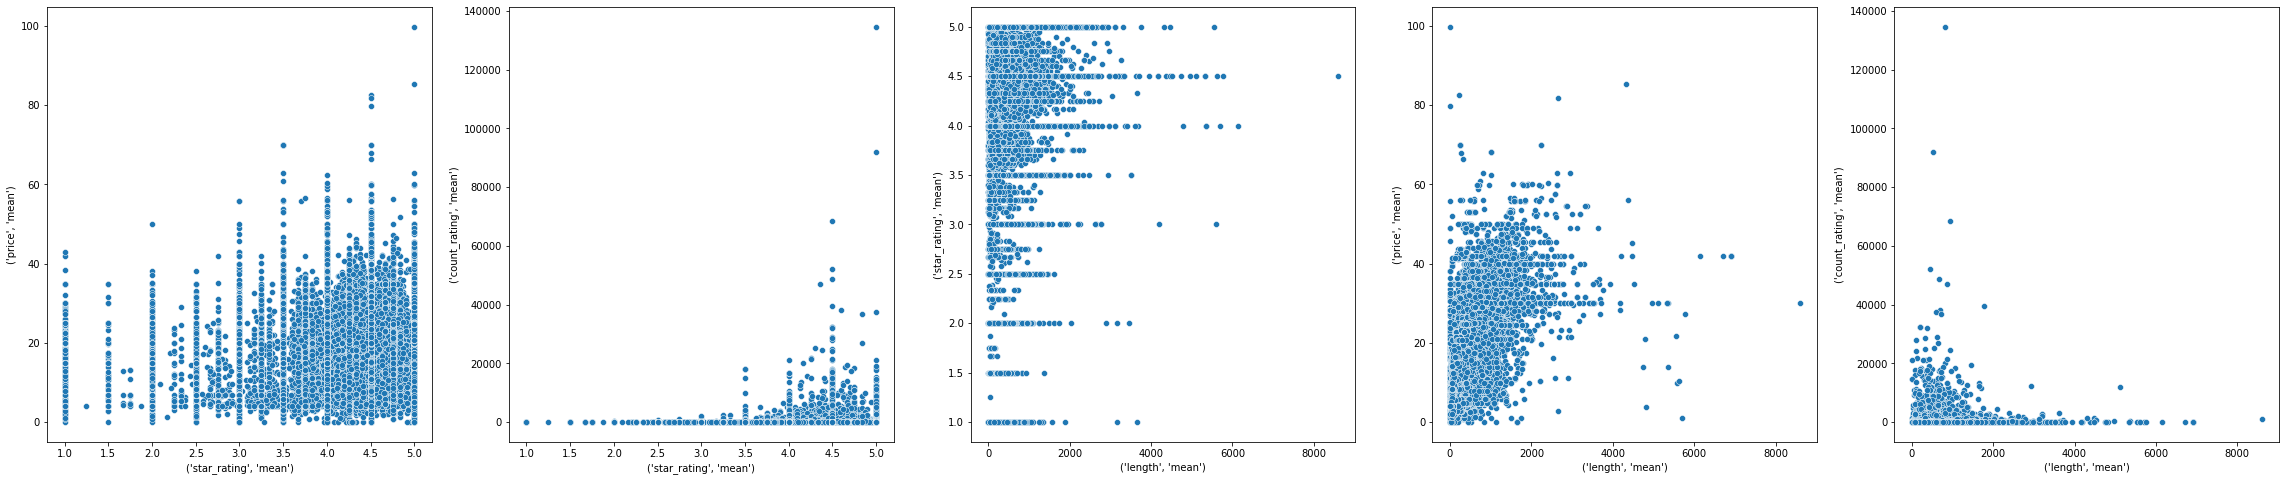

In [143]:
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = auth_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = auth_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = auth_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = auth_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = auth_stats,
                ax= axs[4])

<AxesSubplot:xlabel="('length', 'mean')", ylabel="('count_rating', 'mean')">

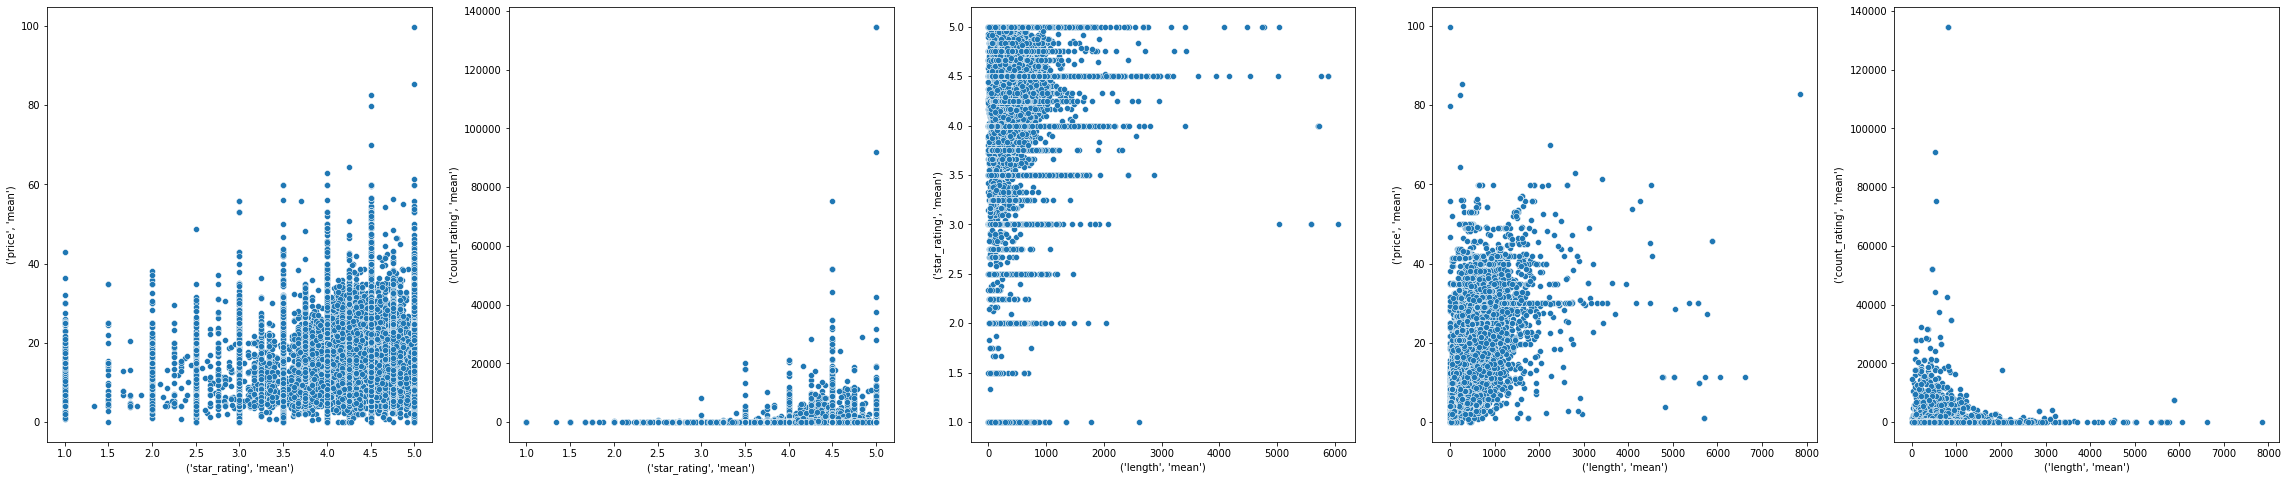

In [145]:
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = narr_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = narr_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = narr_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = narr_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = narr_stats,
                ax= axs[4])

<AxesSubplot:xlabel='author', ylabel='category_number'>

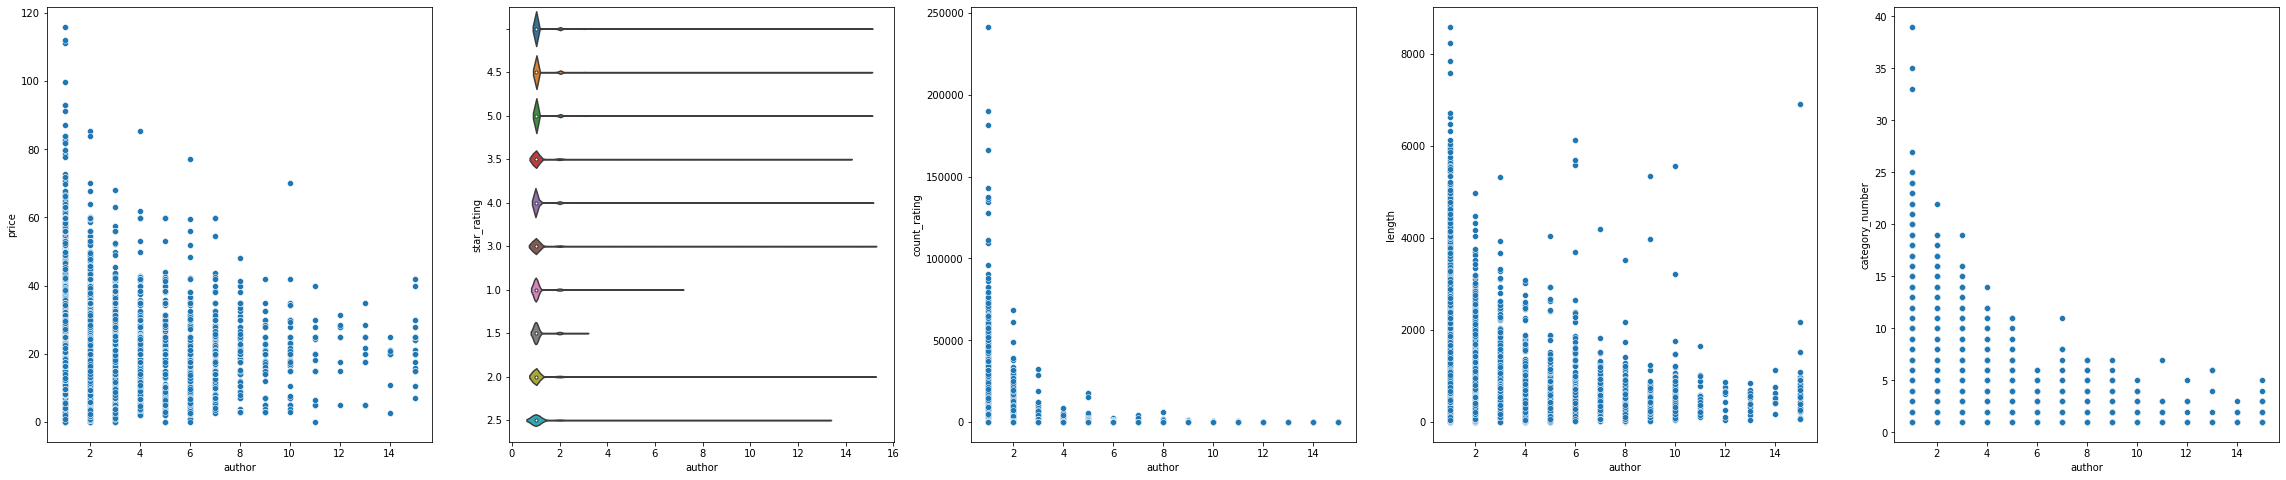

In [104]:
n_author   = titles.author.str.len()

fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= n_author,
                y= titles.price,
                ax= axs[0])
sns.violinplot(x= n_author,
                y= titles.star_rating,
                ax= axs[1],
              )
sns.scatterplot(x=n_author,
                y=titles.count_rating,
               data = titles,
                ax= axs[2])
sns.scatterplot(x=n_author,
                y=titles.length,
               data = titles,
                ax= axs[3])
sns.scatterplot(x=n_author,
                y=titles.category_number,
               data = titles,
                ax= axs[4])




<AxesSubplot:xlabel='narrator', ylabel='category_number'>

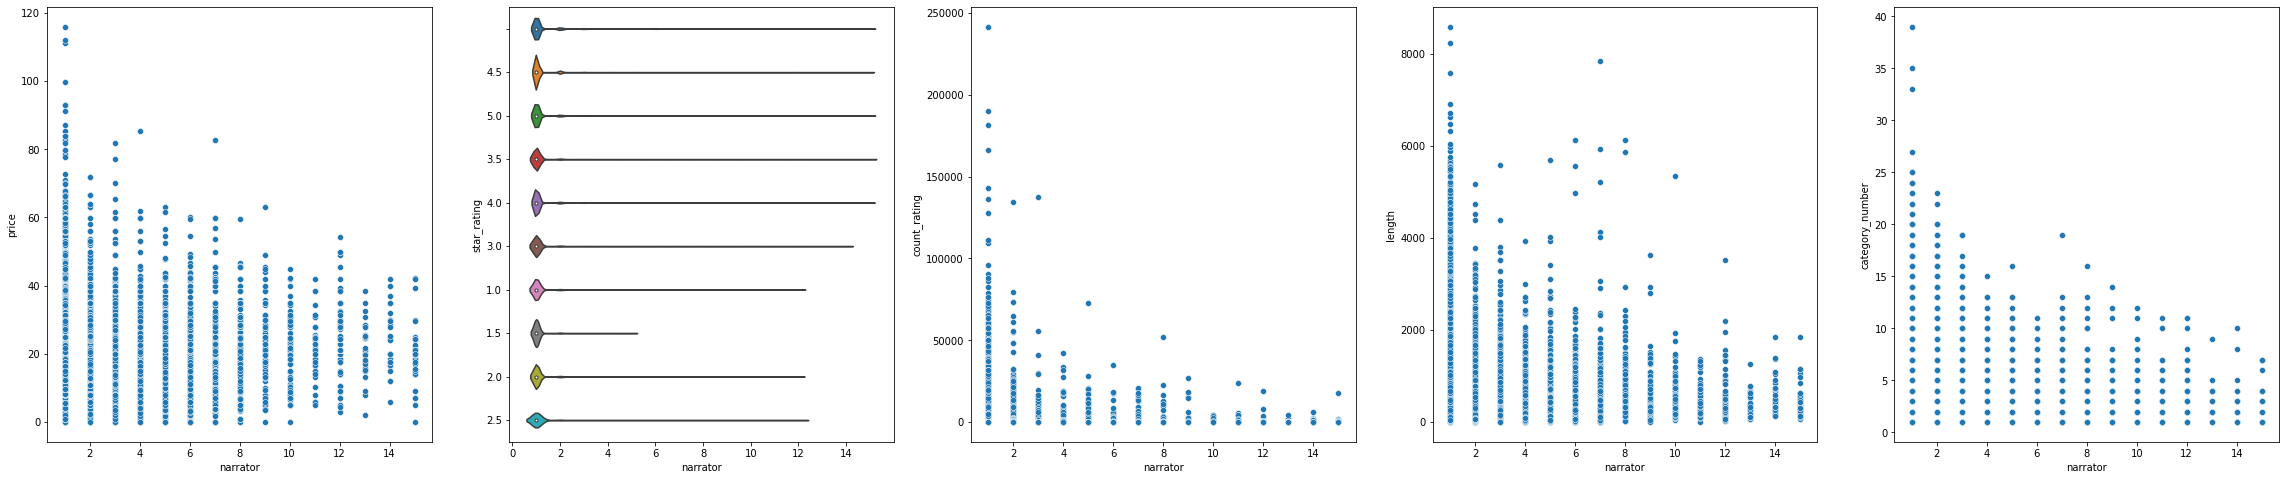

In [105]:
n_narrator = titles.narrator.str.len()

fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= n_narrator,
                y= titles.price,
                ax= axs[0])
sns.violinplot(x= n_narrator,
                y= titles.star_rating,
                ax= axs[1],
              )
sns.scatterplot(x=n_narrator,
                y=titles.count_rating,
               data = titles,
                ax= axs[2])
sns.scatterplot(x=n_narrator,
                y=titles.length,
               data = titles,
                ax= axs[3])
sns.scatterplot(x=n_narrator,
                y=titles.category_number,
               data = titles,
                ax= axs[4])

### Author as Narrator <a id='auth_as_narr'></a>

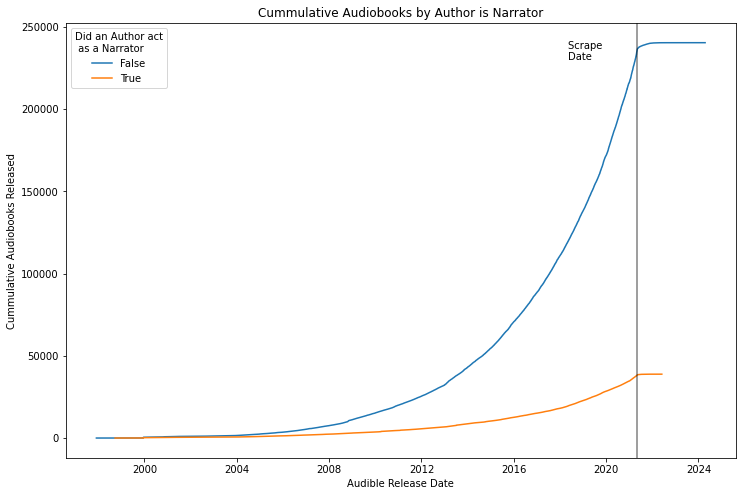

In [91]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
titles['cumm_self_nar'] = titles.sort_values('pub_datetime', ascending = True).groupby('self_narrator',dropna=True).cumcount()

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_self_nar',
             hue = 'self_narrator',
             ci  = None)

plt.title("Cummulative Audiobooks by Author is Narrator")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Did an Author act\n as a Narrator")

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),230000, "Scrape \nDate", color ='k')

plt.rcParams['figure.figsize'] = (8,8)


plt.savefig("./graphics/self_narr_timeseries.png", bbox_inches = 'tight')

There does not seem to be a clear difference between the author acting as narrator vs another actor, across Price, Length, number of ratings, and the number of categories. 

<AxesSubplot:xlabel='self_narrator', ylabel='category_number'>

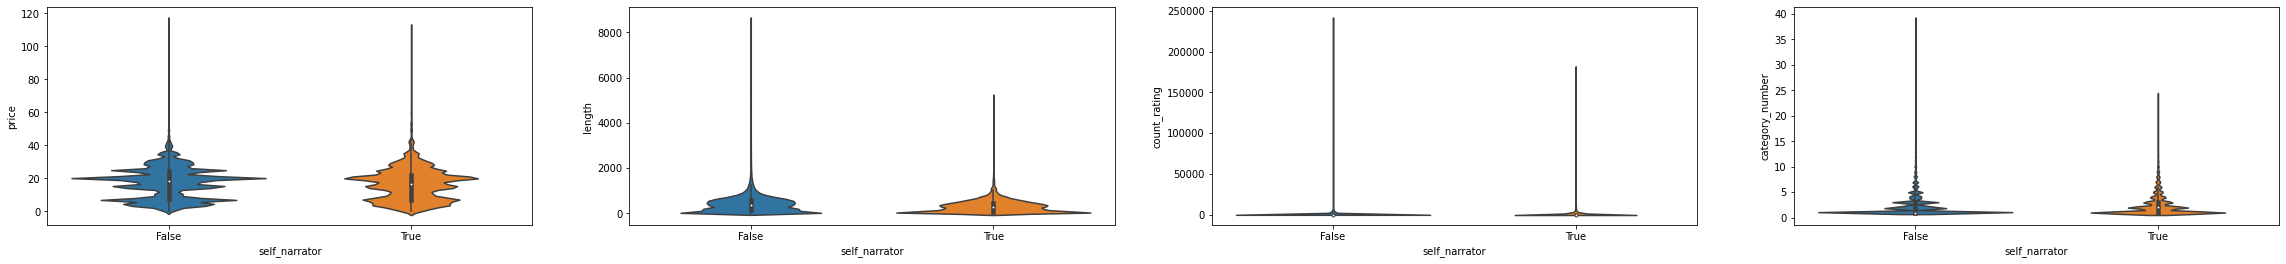

In [147]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
fig, axs = plt.subplots(ncols=4)
fig.set_figwidth(40)
sns.violinplot(x='self_narrator',
                y='price',
               data = titles,
                ax= axs[0])
sns.violinplot(x='self_narrator',
                y='length',
               data = titles,
                ax= axs[1],
              )
sns.violinplot(x='self_narrator',
                y='count_rating',
               data = titles,
                ax= axs[2])
sns.violinplot(x='self_narrator',
                y='category_number',
               data = titles,
                ax= axs[3])

#plt.savefig("./graphics/author_narr_comparisons.png", bbox_inches = 'tight')

# Languages <a id='lang'></a>

In [84]:
s         = "There are {} languages represented in Audible's library."
numb_lang = len(titles.language.unique())

print(s.format(numb_lang))

There are 44 languages represented in Audible's library.


A large majority of audiobooks are narrated and avalible in English.

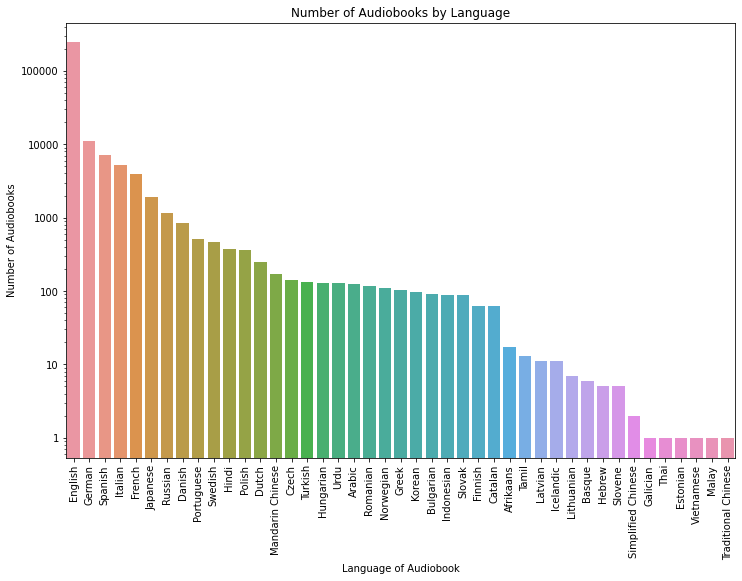

In [85]:
titles['language'] = titles['language'].str.replace("_"," ").str.title()

plot = sns.countplot(x='language', 
                     data = titles, 
                     order = titles['language'].value_counts().index)

plot.set_yscale('log')
plot.set_xlabel("Language of Audiobook")
plot.set_ylabel("Number of Audiobooks")

plt.xticks(rotation =90)
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

plt.title("Number of Audiobooks by Language")
plt.rcParams['figure.figsize'] = (8,8)

plt.savefig("./graphics/languages.png", bbox_inches = 'tight')

English language audiobooks are the largest language and show no signs of stopping. We can even see the expected releases in the coming years. 

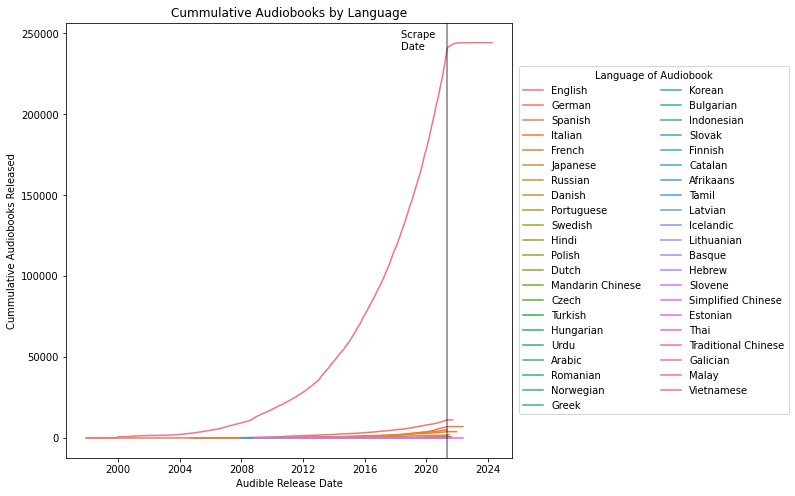

In [81]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()
titles['language'] = titles['language'].str.replace("_"," ").str.title()
lang_order = titles.language.value_counts().sort_values(ascending = False)


plt.rcParams['figure.figsize'] = (8,8)

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_lang_pub',
             hue = titles['language'],
             hue_order= lang_order.index,
             ci  = None)

plt.title("Cummulative Audiobooks by Language")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Language of Audiobook",
            loc='center right', 
            bbox_to_anchor=(1.63, 0.5), 
            ncol=2)

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/lang_timeseries.png", bbox_inches = 'tight')

English accounts for 87% of all titles and languages offered through ACX cover 95% of audibles titles. Most likely because the ACX service was used in their production.

In [134]:
total_titles = titles.shape[0]
titles_by_lang = (titles.value_counts("language")).sort_values(ascending=False)
percent_titles = (titles_by_lang / total_titles*100).sort_values(ascending=False)

print('\nNumber of titles by language')
print(titles_by_lang[0:5])

print('\nPercent of titles by language')
print(percent_titles[0:5])

print('\nPercent Covered by ACX Producers {:.1f}'.format(percent_titles[['English','French','German','Spanish']].sum()))


Number of titles by language
language
English    244156
German      11195
Spanish      7082
Italian      5165
French       3932
dtype: int64

Percent of titles by language
language
English    87.452809
German      4.009872
Spanish     2.536660
Italian     1.850021
French      1.408380
dtype: float64

Percent Covered by ACX Producers 95.4


# Price Distribution <a id='price'></a>

There are 2539 audiobooks greater than $40.


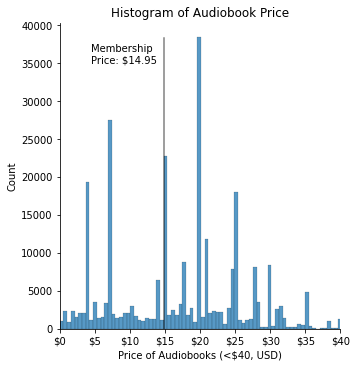

In [65]:
plot = sns.displot(titles.price, kind = 'hist')

plt.axvline(14.90, 0, 0.95, color = 'k', alpha = 0.5) # price adjusted for visual clarity
plt.text(x=4.5, y=35000, s= "Membership \nPrice: $14.95", color = 'k')

plot.set_axis_labels("Price of Audiobooks (<$40, USD)")
plt.title("Histogram of Audiobook Price")

plt.xlim(0,40)

xticks = ["$"+str(x) for x in range(0,41,5)]
plot.set_xticklabels(xticks)

plt.savefig("./graphics/hist_price.png", bbox_inches = 'tight')

print("There are {} audiobooks greater than $40.".format(titles[titles.price>40].shape[0]))

https://kenthendricks.com/audible-pricing/

In [93]:
price_str = titles['price'].astype(str).apply(lambda x: "$"+x)
price_str = price_str.groupby(price_str).size().sort_values(ascending= False)[0:10].to_frame()
price_str.columns = ['Number of Books']

print("Median Price: {}".format(titles.price.astype(str).median()))
print("Most Common Prices for audiobooks")
price_str

Median Price: 18.16
Most Common Prices for audiobooks


,Number of Books
price,
$19.95,35103
$6.95,24551
$14.95,22088
$3.95,16837
$24.95,15953
$17.49,7144
$20.99,6818
$27.99,4211
$29.95,4060


There are 158886 Audiobooks more expensive than the $14.95 membership fee.
There are 120416 Audiobooks cheaper than the $14.95 membership fee.
56.9% of audiobooks are more expensive than the membership


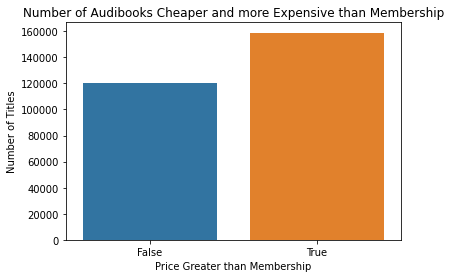

In [110]:
price_split = titles.price.groupby(titles.price>14.95).size().to_frame()

s1 = "There are {} Audiobooks more expensive than the $14.95 membership fee."
s2 = "There are {} Audiobooks cheaper than the $14.95 membership fee."

print(s1.format(price_split.loc[True]['price']))
print(s2.format(price_split.loc[False]['price']))
print("{:.1f}% of audiobooks are more expensive than the membership".format((price_split.loc[True]['price'] / titles.shape[0])*100))

plot = sns.barplot(x = price_split.index, y = price_split.price)                
plot.set(xlabel="Price Greater than Membership", ylabel = "Number of Titles")

plt.title("Number of Audibooks Cheaper and more Expensive than Membership")

plt.savefig("./graphics/price_membership.png", bbox_inches = 'tight')

# Length Distribution <a id='length'></a>

On a [y combinator blog](https://news.ycombinator.com/item?id=27108326), a poster mentioned that audiobooks > 3 hours in length get a royalty rate compared to shorter books


5.866666666666666
6.6432441096616595


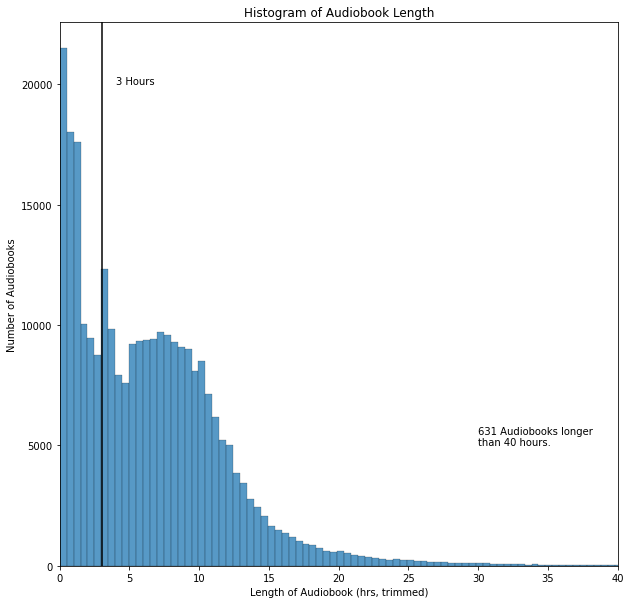

In [20]:
plot = sns.histplot(x = (titles.length/60),bins = 288)

plot.set_xlabel("Length of Audiobook (hrs, trimmed)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Length")
plt.xlim(0,40)
plt.rcParams['figure.figsize'] = (10,10)

plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
plt.text(x=4, y=20000, s= "3 Hours", color = 'k')

plt.text(x=30, y=5000, s= "{} Audiobooks longer\nthan 40 hours.".format(titles[titles.length>2400].shape[0]), color = 'k')

plt.savefig("./graphics/hist_length.png", bbox_inches = 'tight')

print(titles.length.median()/60)
print(titles.length.mean()/60)

#top 3 longest.
#All DEAD
#https://www.audible.com/pd/All-DEAD-Audiobook/B07YF3XH93
#Natsume Soseki Masterpiece Collection
#https://www.audible.com/search?keywords=%E5%A4%8F%E7%9B%AE%E6%BC%B1%E7%9F%B3%E5%90%8D%E4%BD%9C%E9%9B%86&ref=a_search_t1_header_search
#Complete Works of Mimei Ogawa Fairy Tales
#https://www.audible.com/pd/705-Audiobook/B07JY9D1Q7?qid=1621966151&sr=1-1&ref=a_search_c3_lProduct_1_1&pf_rd_p=83218cca-c308-412f-bfcf-90198b687a2f&pf_rd_r=W7X2DH66FXW439HDZW9G

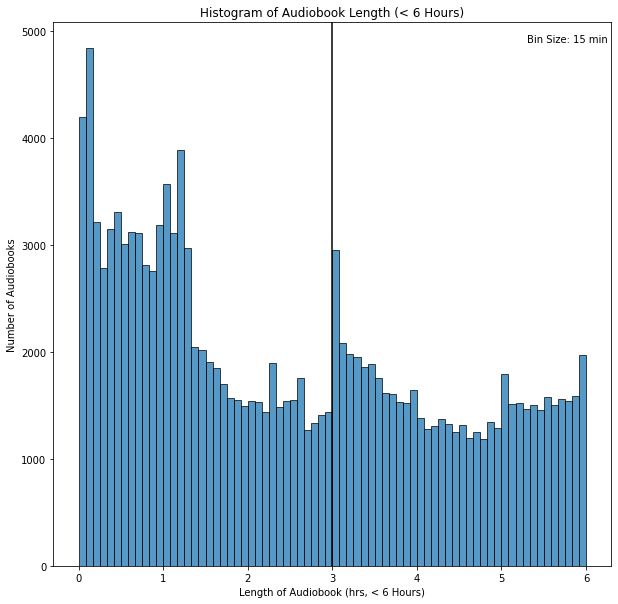

In [138]:
data = titles[(titles.length/60) <= 6]['length']/60
plot = sns.histplot(x =data, bins = 72)

plot.set_xlabel("Length of Audiobook (hrs, < 6 Hours)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Length (< 6 Hours)")

plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
plt.text(x=5.3, y=4900, s= "Bin Size: 15 min", color = 'k')

plt.savefig("./graphics/hist_under_6.png", bbox_inches = 'tight')

# Bang for your Buck <a id='band4buck'></a>

In [71]:
data         = titles[(titles[['price','length']].notnull().all(1)) & (titles.length > 0) & (titles.star_rating != "") & (titles.price != 0)]
hr_per_USD   = (data.length/60) / (data.price)
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order.reverse()

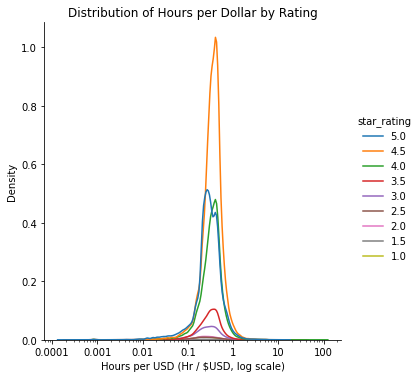

In [91]:
plot = sns.displot(x = hr_per_USD, hue= data.star_rating, log_scale= True, kind = 'kde', legend = True, hue_order=star_order)

plt.xlabel("Hours per USD (Hr / $USD, log scale)")
plt.title("Distribution of Hours per Dollar by Rating")

xticks = [0.0001,0.001,0.01,0.1,1,10,100]
plt.xticks(xticks,xticks)

plt.savefig("./graphics/hours_per_USD_dist.png", bbox_inches = 'tight')




# Reviews & Ratings <a id='reviews'></a>

There are 63664 audiobooks without a review


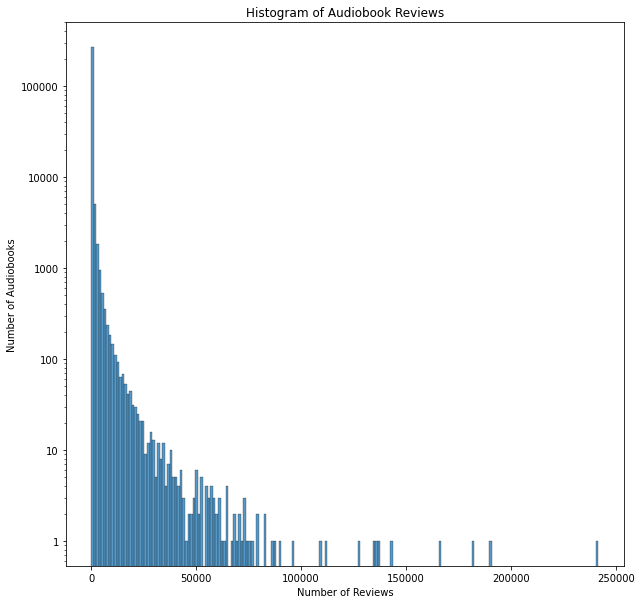

In [98]:
plot = sns.histplot(x = titles.count_rating, bins = 200)

plot.set_xlabel("Number of Reviews")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Reviews")
plot.set_yscale('log')

yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

print("There are {} audiobooks without a review".format(titles.loc[(titles.release_date <= '2021-05-10') & (titles.count_rating == 0)].shape[0]))
plt.savefig("./graphics/hist_reviews.png", bbox_inches = 'tight')

In [24]:
titles.sort_values('count_rating', ascending=False)[0:4]

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub
82110,[Ernest Cline],English,[Wil Wheaton],False,31.50,,Ready Player One,https://www.audible.com/pd/Ready-Player-One-Au...,08-16-11,940,5.0,241735.0,"[Action & Adventure, All Categories, Genre Fic...",9,2011-08-16,25910
64582,[Delia Owens],English,[Cassandra Campbell],False,31.50,,Where the Crawdads Sing,https://www.audible.com/pd/Where-the-Crawdads-...,08-14-18,732,5.0,190374.0,"[All Categories, Literary Fiction, Coming of A...",7,2018-08-14,133531
263990,[Trevor Noah],English,[Trevor Noah],False,24.95,Stories from a South African Childhood,Born a Crime,https://www.audible.com/pd/Born-a-Crime-Audiob...,11-15-16,524,5.0,181458.0,"[Entertainment & Celebrities, Comedy, Entertai...",6,2016-11-15,91891
190501,[Michelle Obama],English,[Michelle Obama],False,35.71,,Becoming,https://www.audible.com/pd/Becoming-Audiobook/...,11-13-18,1143,5.0,166488.0,"[Women, Biographies & Memoirs, All Categories,...",7,2018-11-13,140995


In [23]:
#some difference between the spouses
titles[titles.title == 'A Promised Land'].head(1)

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub
22675,[Barack Obama],English,[Barack Obama],False,45.5,,A Promised Land,https://www.audible.com/pd/A-Promised-Land-Aud...,11-17-20,1750,5.0,35818.0,"[Biographies & Memoirs, All Categories, United...",9,2020-11-17,214818


# Rate of count ratings, when did they occur during lifetime of book?

## Star Rating

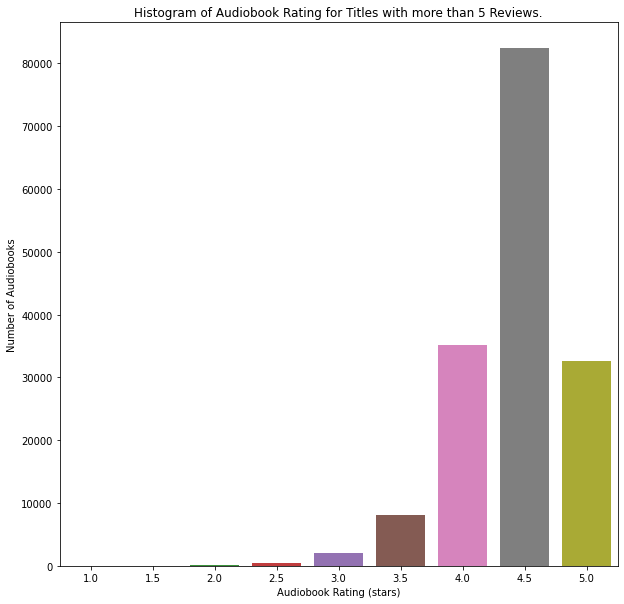

In [97]:
plot = sns.countplot(x = titles[titles.count_rating > 5]['star_rating'])

plot.set_xlabel("Audiobook Rating (stars)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Rating for Titles with more than 5 Reviews.")

plt.savefig("./graphics/hist_stars.png", bbox_inches = 'tight')

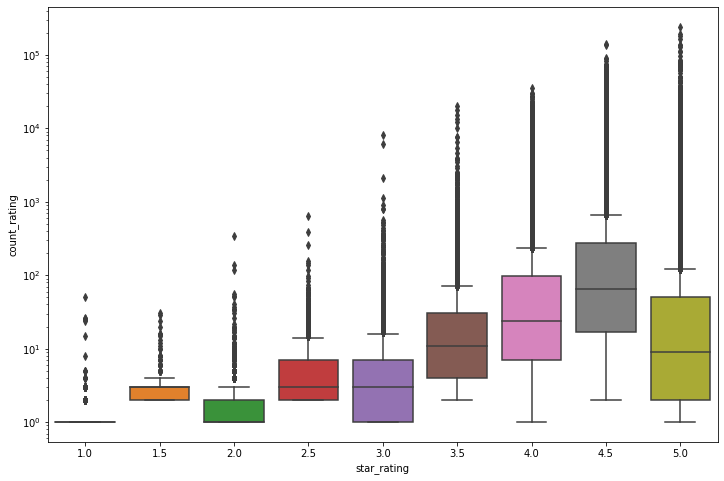

In [110]:
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order

sns.boxplot(x=titles.star_rating,
           y=titles.count_rating, order = star_order)

plt.yscale('log')

Price vs star_rating

<AxesSubplot:xlabel='star_rating', ylabel='price'>

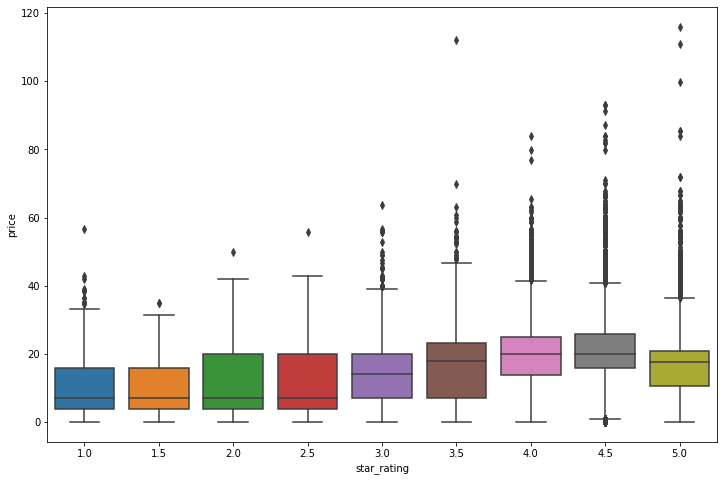

In [276]:
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order

sns.boxplot(x=titles.star_rating,
           y=titles.price, order = star_order)

#plt.yscale('log')

# Number of Categories <a id='categories'></a>

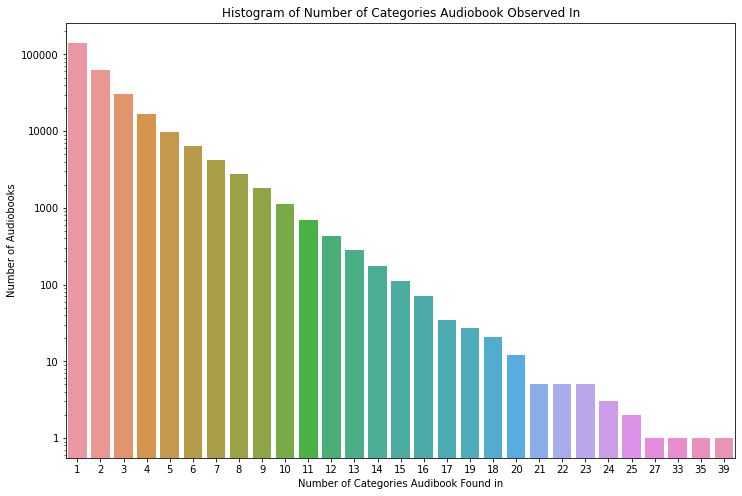

In [78]:
plot = sns.countplot(x='category_number', 
                     data = titles, 
                     order = titles['category_number'].value_counts().index)

plot.set_xlabel("Number of Categories Audibook Found in")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Number of Categories Audiobook Observed In")

plt.savefig("./graphics/cat_numb_hist.png", bbox_inches = 'tight')

plot.set_yscale('log')
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)
plt.savefig("./graphics/cat_numb_log_hist.png", bbox_inches = 'tight')

Titles in the most categories seem to be about major social events or 

In [139]:
titles.sort_values('category_number', ascending = False).head(4)

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number
260381,Timothy Snyder,English,Ralph Cosham,False,29.95,Europe Between Hitler and Stalin,Bloodlands,https://www.audible.com/pd/Bloodlands-Audioboo...,10-12-18,1096,5.0,390.0,"[United States, Austria & Hungary, Russia, Gre...",39
241047,Sherry Turkle,English,Laural Merlington,False,31.49,Why We Expect More from Technology and Less fr...,Alone Together,https://www.audible.com/pd/Alone-Together-Audi...,05-10-11,885,3.5,210.0,"[Philosophy, Workplace Culture, Workplace & Or...",35
30885,Brendan Simms,English,Leighton Pugh,False,30.79,A Global Biography,Hitler,https://www.audible.com/pd/Hitler-Audiobook/15...,10-01-19,1757,4.5,46.0,"[Japan, Austria & Hungary, Asia, Russia, Italy...",33


In [171]:
titles_categories = titles.explode('title_category')
titles_categories['star_rating'] = titles_categories.star_rating.replace("",np.nan).astype(float)

cat_stats = titles_categories.groupby('title_category').agg({'star_rating':'mean','count_rating':['mean','sum'],'length':'mean', 'price':'mean','language':'nunique','title':'count'})

In [165]:
cat_stats.sort_values(('star_rating','mean'), ascending = False)[0:5]#.index

star_rating count_rating                length  \
                             mean         mean       sum        mean   
title_category                                                         
Math                     4.875000    12.635135     935.0   92.702703   
Christian Living         4.778205   531.103333  637324.0  420.316667   
Ministry & Evangelism    4.777211   307.538333  369046.0  474.975000   
Spiritual Growth         4.775237   390.070000  468084.0  403.979167   
Christianity             4.758929   641.391667  769670.0  582.339167   

                           price language title  
                            mean  nunique count  
title_category                                   
Math                    8.820946        2    74  
Christian Living       21.334700        2  1200  
Ministry & Evangelism  20.994583        2  1200  
Spiritual Growth       20.907092        2  1200  
Christianity           22.620933        2  1200

In [182]:
cat_stats.sort_values(('star_rating','mean'), ascending = True)[0:5]#.index

star_rating count_rating             length     price  \
                        mean         mean    sum        mean      mean   
title_category                                                           
Hebrew              3.295455     1.132231  137.0  150.619835  9.685455   
Slavic Languages    3.340000     0.330049  134.0  169.908867  9.722094   
Turkish             3.357143     0.311239  108.0  158.028818  9.722219   
Hungarian           3.375000     0.476744   41.0  166.651163  9.604651   
Serbo-Croatian      3.400000     0.300000   24.0  148.600000  9.635250   

                 language title  
                  nunique count  
title_category                   
Hebrew                 26   121  
Slavic Languages       26   406  
Turkish                26   347  
Hungarian              24    86  
Serbo-Croatian         25    80

In [174]:
cat_stats.sort_values(('count_rating','mean'), ascending = False)[0:5]#.index

star_rating  count_rating  \
                                                       mean          mean   
title_category                                                              
All Categories                                     4.652705  11056.617181   
Suspense                                           4.435512   5287.598997   
Genre Fiction                                      4.358689   4197.723461   
Literary Fiction                                   4.349642   3751.103101   
Relationships, Parenting & Personal Development    4.653361   3084.012500   

                                                                 length  \
                                                        sum        mean   
title_category                                                            
All Categories                                   13256884.0  742.741451   
Suspense                                          6329256.0  728.437761   
Genre Fiction                                     7908511.0  696.728238   
Literary Fiction                                  4838923.0  784.781395   
Relationships, Parenting & Personal Development   3700815.0  471.141667   

                                                     price language title  
                                                      mean  nunique count  
title_category                                                             
All Categories                                   28.063028        2  1199  
Suspense                                         27.807444        1  1197  
Genre Fiction                                    25.512956        7  1884  
Literary Fiction                                 27.912426        7  1290  
Relationships, Parenting & Personal Development  22.551225        3  1200

In [181]:
cat_stats.sort_values(('count_rating','mean'), ascending = True)[0:5]#.index

star_rating count_rating             length     price  \
                        mean         mean    sum        mean      mean   
title_category                                                           
Flowers & Plants    4.285714     0.156863    8.0   23.470588  5.217843   
Serbo-Croatian      3.400000     0.300000   24.0  148.600000  9.635250   
Turkish             3.357143     0.311239  108.0  158.028818  9.722219   
Slavic Languages    3.340000     0.330049  134.0  169.908867  9.722094   
Hungarian           3.375000     0.476744   41.0  166.651163  9.604651   

                 language title  
                  nunique count  
title_category                   
Flowers & Plants        5    51  
Serbo-Croatian         25    80  
Turkish                26   347  
Slavic Languages       26   406  
Hungarian              24    86

In [164]:
cat_stats.sort_values(('length','mean'), ascending = False)[0:5]#.index

star_rating count_rating                 length  \
                           mean         mean        sum        mean   
title_category                                                        
Americas               4.541281  1269.841667  1523810.0  881.560833   
Politics & Activism    4.489206   929.019167  1114823.0  865.569167   
Epic                   4.566885  2269.242359  5271450.0  851.352561   
Individual Wars        4.510239   587.680833   705217.0  850.184167   
Sagas                  4.424851   975.937500  1171125.0  822.236667   

                         price language title  
                          mean  nunique count  
title_category                                 
Americas             29.327292        2  1200  
Politics & Activism  28.805933        6  1200  
Epic                 26.764537       10  2323  
Individual Wars      27.751208        3  1200  
Sagas                27.055925        5  1200

In [180]:
cat_stats.sort_values(('length','mean'), ascending = True)[0:5]#.index

star_rating count_rating              length  \
                               mean         mean      sum       mean   
title_category                                                         
Nursery Rhymes             4.546512     2.202532    348.0  16.335443   
Beginner Readers           4.361809     9.481100  11036.0  17.793814   
Flowers & Plants           4.285714     0.156863      8.0  23.470588   
Oceans & Water             4.500000     0.812500     39.0  26.687500   
Ducks & Other Waterfowl    4.421053    13.181159   1819.0  32.847826   

                            price language title  
                             mean  nunique count  
title_category                                    
Nursery Rhymes           4.936013        6   158  
Beginner Readers         5.023093        6  1164  
Flowers & Plants         5.217843        5    51  
Oceans & Water           6.173542        3    48  
Ducks & Other Waterfowl  5.698986        6   138

In [170]:
cat_stats.sort_values(('price','mean'), ascending = False)[0:5]#.index

star_rating  count_rating                  length  \
                             mean          mean         sum        mean   
title_category                                                            
Americas                 4.541281   1269.841667   1523810.0  881.560833   
Politics & Activism      4.489206    929.019167   1114823.0  865.569167   
Politics & Government    4.587585   1504.155833   1804987.0  819.077500   
All Categories           4.652705  11056.617181  13256884.0  742.741451   
Literary Fiction         4.349642   3751.103101   4838923.0  784.781395   

                           price language title  
                            mean  nunique count  
title_category                                   
Americas               29.327292        2  1200  
Politics & Activism    28.805933        6  1200  
Politics & Government  28.306592        2  1200  
All Categories         28.063028        2  1199  
Literary Fiction       27.912426        7  1290

In [179]:
cat_stats.sort_values(('price','mean'), ascending = True)[0:5]#.index

star_rating count_rating              length     price  \
                        mean         mean      sum       mean      mean   
title_category                                                            
Nursery Rhymes      4.546512     2.202532    348.0  16.335443  4.936013   
Beginner Readers    4.361809     9.481100  11036.0  17.793814  5.023093   
Flowers & Plants    4.285714     0.156863      8.0  23.470588  5.217843   
Early Readers       4.475309     4.529167   5435.0  51.457500  5.451525   
Easter              4.542857     5.658824    481.0  39.729412  5.627765   

                 language title  
                  nunique count  
title_category                   
Nursery Rhymes          6   158  
Beginner Readers        6  1164  
Flowers & Plants        5    51  
Early Readers          13  1200  
Easter                  4    85

In [173]:
cat_stats.sort_values(('language','nunique'), ascending = False)[0:5]#.index

star_rating count_rating               length  \
                                 mean         mean      sum        mean   
title_category                                                            
Southeast Asian Languages    3.406250     0.479830    226.0  175.972399   
Chinese Languages            4.321429     4.821306   1403.0  199.288660   
French                       4.325167    17.131944  14802.0  172.083333   
Russian                      4.296610    18.972337  13717.0  296.561549   
German                       4.329167     8.485030   7085.0  133.699401   

                               price language title  
                                mean  nunique count  
title_category                                       
Southeast Asian Languages   9.964628       28   471  
Chinese Languages          12.149175       27   291  
French                     10.871146       26   864  
Russian                    10.574952       26   723  
German                      9.938874       26   835

In [178]:
cat_stats.sort_values(('language','nunique'), ascending = True)[0:5]#.index

star_rating count_rating           \
                                         mean         mean      sum   
title_category                                                        
Thanksgiving                         4.345238     8.000000    600.0   
Amish & Mennonite                    4.472754    58.417293  46617.0   
Step Parenting & Blended Families    4.214286    35.866667   1614.0   
Asian American Studies               4.204918   114.602740   8366.0   
Gender-Specific Topics               4.388889    44.173913   3048.0   

                                       length      price language title  
                                         mean       mean  nunique count  
title_category                                                           
Thanksgiving                        36.680000   5.664533        1    75  
Amish & Mennonite                  391.224311  18.860238        1   798  
Step Parenting & Blended Families  360.088889  16.885333        1    45  
Asian American Studies             539.643836  21.923562        1    73  
Gender-Specific Topics             275.768116  17.889565        1    69

<AxesSubplot:xlabel="('title', 'count')", ylabel='Count'>

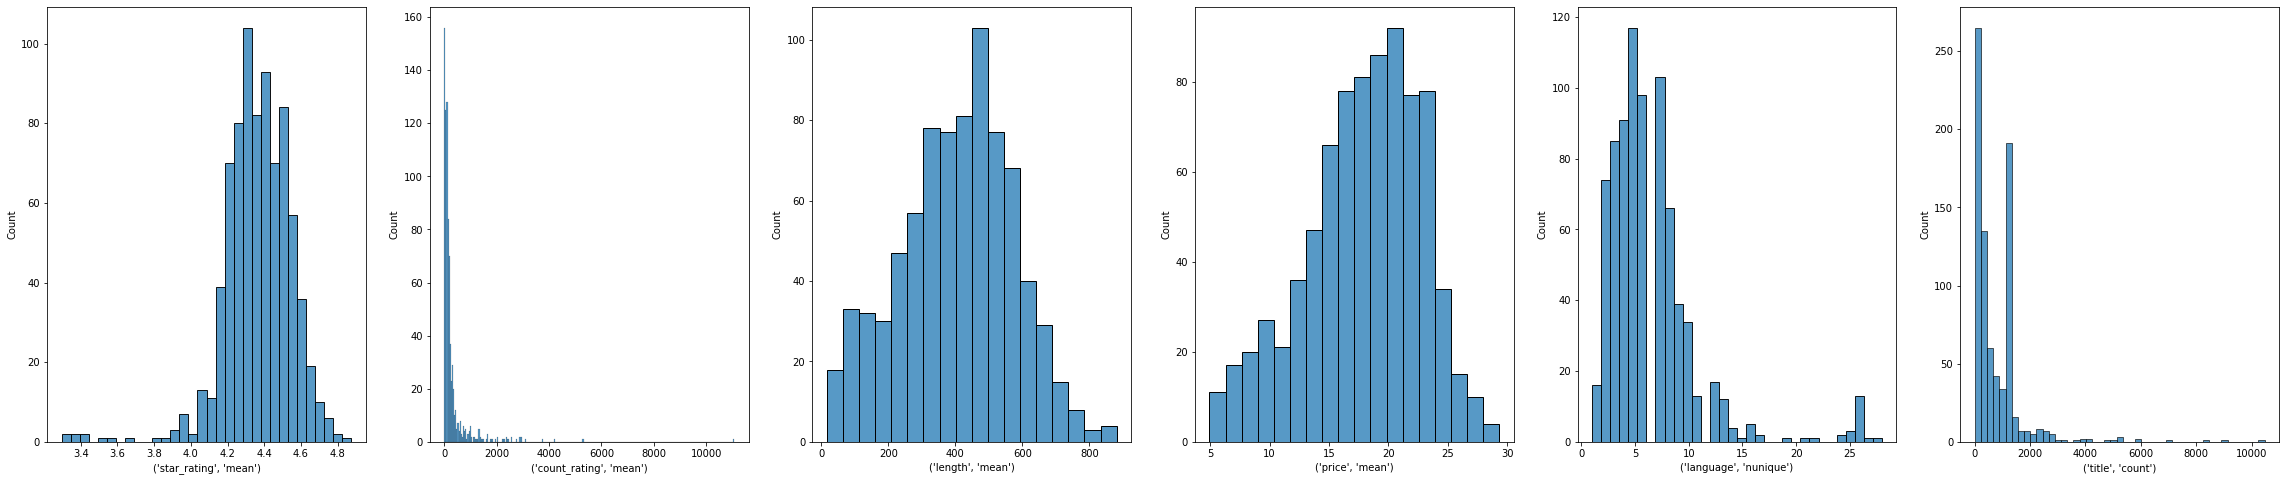

In [183]:
fig, axs = plt.subplots(ncols=6)
fig.set_figwidth(40)
sns.histplot(x= ('star_rating','mean'),
                data = cat_stats,
                ax= axs[0])
sns.histplot(x= ('count_rating','mean'),
                data = cat_stats,
                ax= axs[1],
              )
sns.histplot(x= ('length','mean'),
               data = cat_stats,
                ax= axs[2])
sns.histplot(x= ('price','mean'),
               data = cat_stats,
                ax= axs[3])
sns.histplot(x= ('language','nunique'),
               data = cat_stats,
                ax= axs[4])
sns.histplot(x= ('title','count'),
                data = cat_stats,
                ax= axs[5])

<AxesSubplot:xlabel="('length', 'mean')", ylabel="('count_rating', 'mean')">

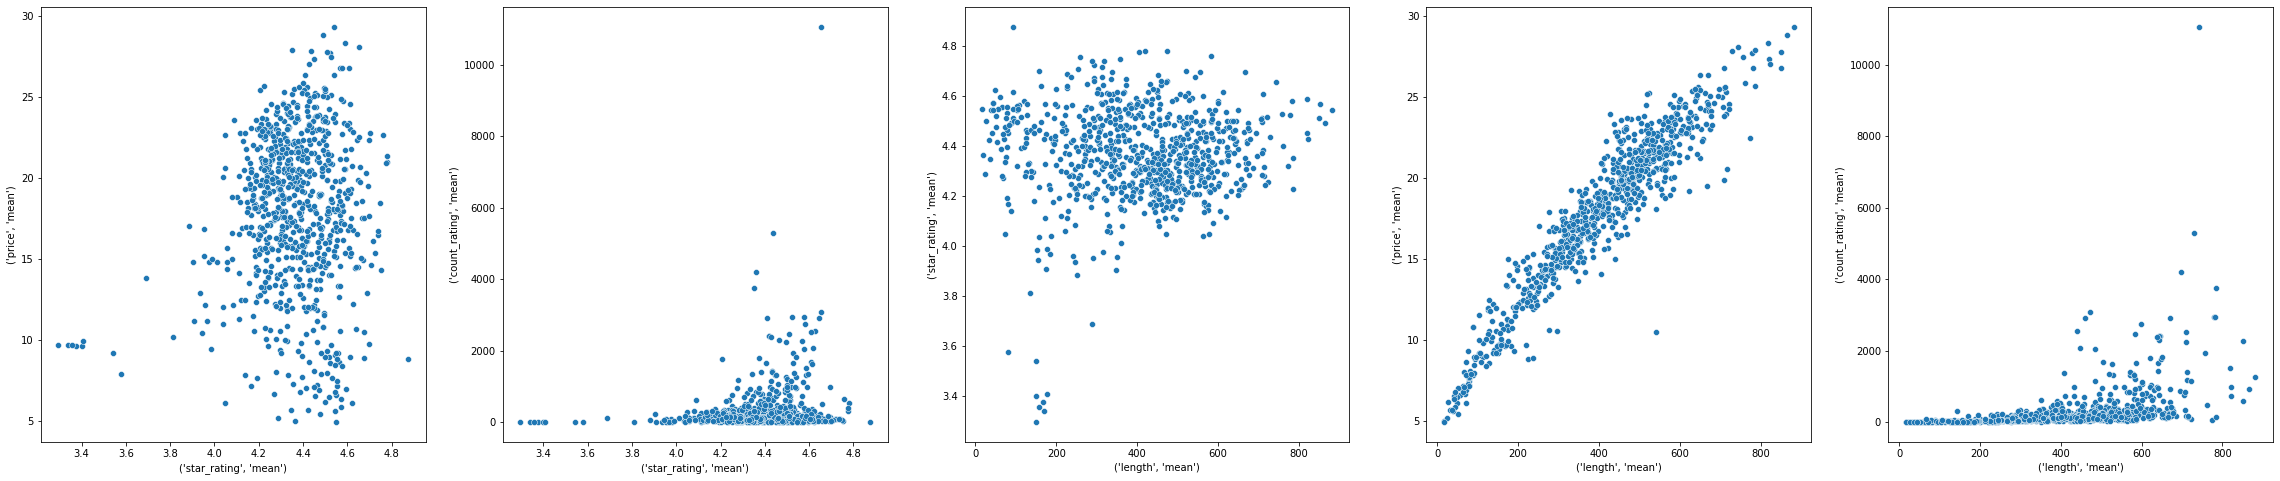

In [175]:
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = cat_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = cat_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = cat_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = cat_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = cat_stats,
                ax= axs[4])

# Length by Price <a id='price_length'></a>

<ipython-input-35-a5de3a3244b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


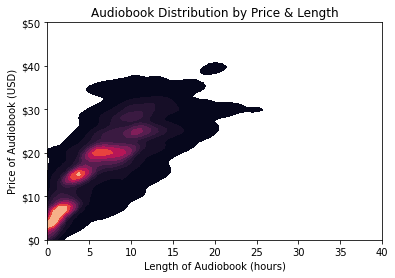

In [35]:
# Warning, takes a while to render

plot = sns.kdeplot(x =(titles.length/60), 
                   y = titles.price,
                   cmap = 'rocket',
                   fill = True)

plt.xlim(0,40)
plt.ylim(0,50)

plt.ylabel("Price of Audiobook (USD)")
plt.xlabel("Length of Audiobook (hours)")
plt.title("Audiobook Distribution by Price & Length")


yticks = ["$"+str(x) for x in range(0,51,10)]
plot.set_yticklabels(yticks)

plt.savefig("./graphics/price_vs_length.png", bbox_inches = 'tight')

[Suggested length vs pricing](https://help.acx.com/s/article/can-i-set-my-pricing)

price
3.95      0.083333
6.95      1.016667
14.95     3.000000
19.95     5.016667
24.95    10.016667
Name: length, dtype: float64


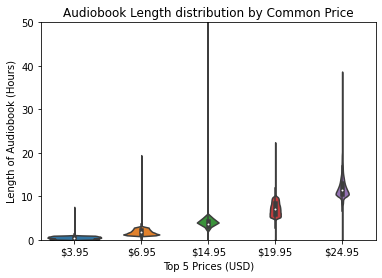

In [180]:
price_common = titles[titles.count_rating >= 1].groupby('price').size().sort_values(ascending= False).index.values[0:5]

data = titles[[x in price_common for x in titles.price]]
price_str = data.price.sort_values(ascending = True).astype(str).apply(lambda x: "$"+x)

print(data.groupby('price').length.agg(mode)/60)



plot = sns.violinplot(x= price_str, y = data.length/60)

plot.set_ylabel("Length of Audiobook (Hours)")
plot.set_xlabel("Top 5 Prices (USD)")
plot.set_title("Audiobook Length distribution by Common Price")

plt.ylim(0,50)


plt.savefig("./graphics/common_prices.png", bbox_inches = 'tight')

In [100]:
titles[(titles['price'] == 14.95) & (titles['length'] >2000)].sort_values('length', ascending=False)

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub
119259,"[Jane Austen, Charles Dickens, Louisa May Alco...",English,"[Charles Hubbell, James Ellis, Stephen Scalon,...",False,14.95,,10 Masterpieces You Have to Read Before You Die 1,https://www.audible.com/pd/10-Masterpieces-You...,11-06-19,6139,3.5,246.0,"[European, World Literature, Classics]",3,2019-11-06,172614
19745,[Arthur Conan Doyle],English,[Stephen Scalon],False,14.95,,The Sherlock Holmes Collection,https://www.audible.com/pd/The-Sherlock-Holmes...,07-11-19,4064,4.5,105.0,"[Traditional Detectives, Anthologies & Short S...",3,2019-07-11,161131
177796,[Mark Twain],English,[Lee Howard],False,14.95,,Mark Twain - The Complete Novels,https://www.audible.com/pd/Mark-Twain-The-Comp...,09-03-19,3513,4.5,55.0,[Classics],1,2019-09-03,165491
88265,[G. K. Chesterton],English,[Stephen Scalon],False,14.95,,The Complete Father Brown Collection,https://www.audible.com/pd/The-Complete-Father...,09-03-19,2488,4.0,100.0,"[Amateur Sleuths, Mystery]",2,2019-09-03,165590


In [115]:
def acx_pricing_lookup(length):
    if length < 1:
        return "Under 1 Hour"
    elif 1 <= length < 3 :
        return "1-3 Hours"
    elif 3 <= length < 5 :
        return "3-5 Hours"
    elif 5 <= length < 10 :
        return "5-10 Hours"
    elif 10 <= length < 20 :
        return "10-20 Hours"
    elif 20 <= length :
        return "More than 20 Hours"

    
    
titles['acx_bin'] = (titles.length/60).apply(acx_pricing_lookup)

# I SHOULD BE A GRAPH, INCLUDE ME

(0.0, 50.0)

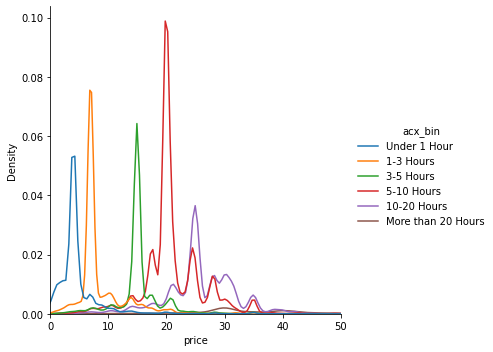

In [117]:
plot = sns.displot(x=titles.price, kind = 'kde', hue = titles.acx_bin,hue_order=["Under 1 Hour", "1-3 Hours","3-5 Hours","5-10 Hours","10-20 Hours","More than 20 Hours"])

plt.xlim(0,50)

acx_bin
Under 1 Hour           3.95
1-3 Hours              6.95
3-5 Hours             14.95
5-10 Hours            19.95
10-20 Hours           24.95
More than 20 Hours    31.18
Name: price, dtype: float64


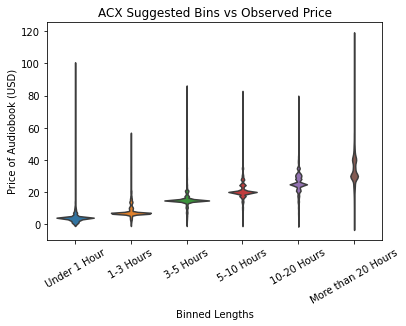

In [179]:
plot = sns.violinplot(x = titles.acx_bin, y = titles.price, inner = None,
                      order=["Under 1 Hour","1-3 Hours","3-5 Hours","5-10 Hours","10-20 Hours","More than 20 Hours"])

plot.set_ylabel("Price of Audiobook (USD)")
plot.set_xlabel("Binned Lengths")
plot.set_title("ACX Suggested Bins vs Observed Price")

plt.xticks(rotation =30)

plt.savefig("./graphics/acx_price_bins.png", bbox_inches = 'tight')

print(titles.groupby('acx_bin').price.median().sort_values())

#### Boring: Price vs Count Rating

<AxesSubplot:xlabel='price', ylabel='count_rating'>

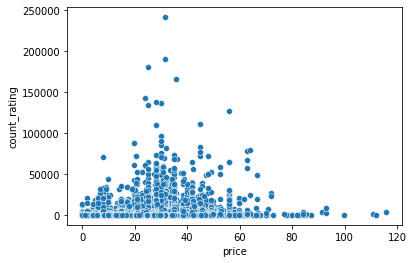

In [160]:
sns.scatterplot(x=titles.price,
               y =titles.count_rating)

<AxesSubplot:xlabel='category_number', ylabel='star_rating'>

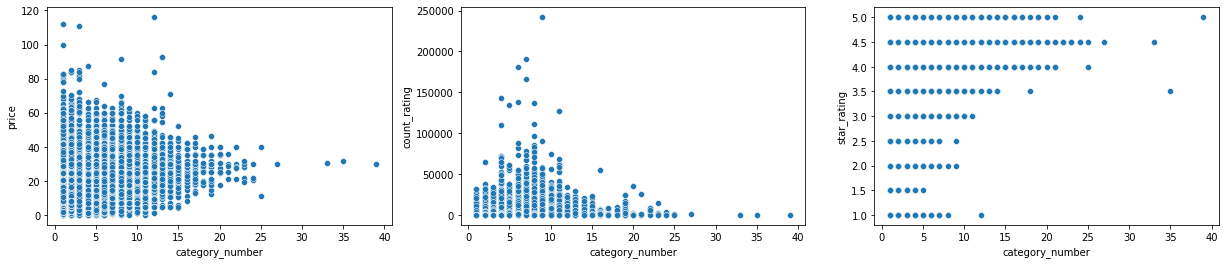

In [45]:
# price, reviews, rating by category number
#popular 

#sns.FacetGrid(titles, col = )


fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(21)
sns.scatterplot(x=titles.category_number,
                y=titles.price,
                ax= axs[0])
sns.scatterplot(x=titles.category_number,
                y=titles.count_rating,
                ax= axs[1])
sns.scatterplot(x=titles.category_number,
                y=titles.star_rating,
                ax= axs[2])


# use density plots

<AxesSubplot:xlabel='length', ylabel='count_rating'>

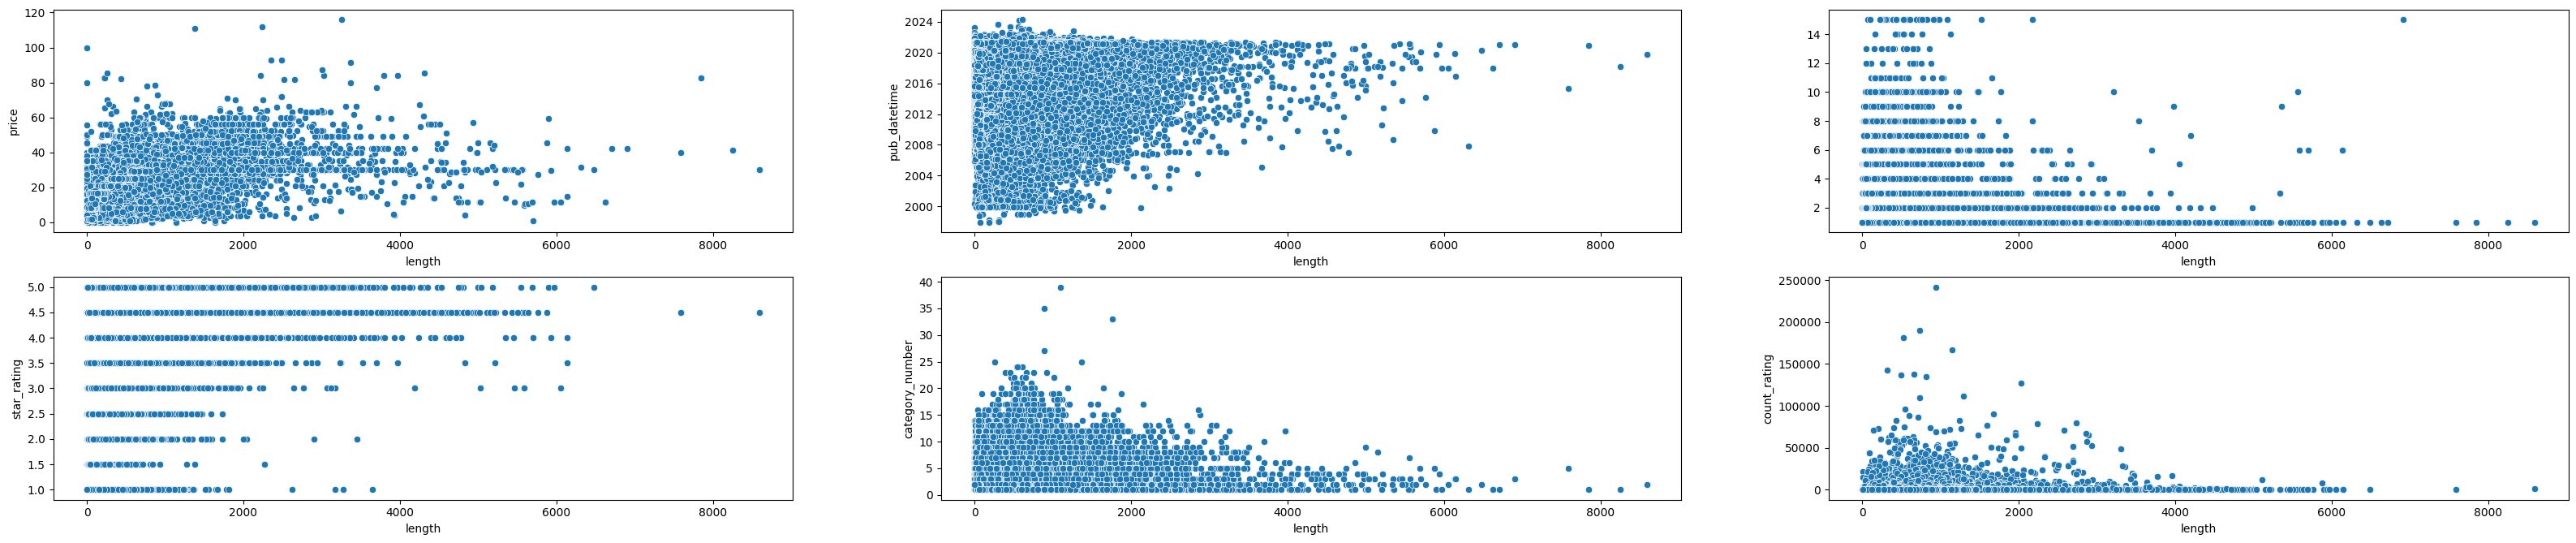

In [271]:
fig, axs = plt.subplots(nrows = 2, ncols=3)
fig.set_figwidth(40)

sns.scatterplot(x=titles.length,
                y=titles.price,
                ax= axs[0,0])
sns.scatterplot(x=titles.length,
                y=titles.pub_datetime,
                ax= axs[0,1])
sns.scatterplot(x=titles.length,
                y=[len(x) for x in titles.author],
                ax= axs[0,2])
sns.scatterplot(x=titles.length,
                y=titles.star_rating,
                ax= axs[1,0])
sns.scatterplot(x=titles.length,
                y=titles.category_number,
                ax= axs[1,1])
sns.scatterplot(x=titles.length,
                y=titles.count_rating,
                ax= axs[1,2])


# Axis Customization
#axs[].ylabel("")
#axs[].xlabel("An Author also Narrated")

# Translation as Revenue Driver <a id='translation'></a>

English language accounts for 91% of all hours of content, 1.7 million hours. This is expected form a company which mainly operates in the US, however only 5% of the global population speaks english.


[Breaking into India market with famous actors](https://yourstory.com/2020/09/audible-suno-amazon-audio-streaming-bet-india/amp)

In [17]:
total_hours = titles.length.sum()/60
total_hours_by_lang = (titles.groupby('language')['length'].sum()/60).sort_values(ascending=False)
percent_hours = (total_hours_by_lang / total_hours_by_lang.sum()*100).sort_values(ascending=False)

print("Total Hours {}".format(total_hours))
print("Total Titles {}".format(titles.shape[0]))
print('\nNumber of Hours by language')
print(total_hours_by_lang[0:3])
print('\nPercent of Total Hours by language')
print(percent_hours[0:3])
print('\nPercent of Total Titles by language')
print((titles.groupby('language')['length'].size() / titles.shape[0]).sort_values(ascending=False)[0:3])


Total Hours 1854700.75
Total Titles 279186

Number of Hours by language
language
English    1.694328e+06
German     5.507983e+04
Spanish    3.738625e+04
Name: length, dtype: float64

Percent of Total Hours by language
language
English    91.353154
German      2.969742
Spanish     2.015756
Name: length, dtype: float64

Percent of Total Titles by language
language
English    0.874528
German     0.040099
Spanish    0.025367
Name: length, dtype: float64


At minimum Audible has 1.53 million hours of non-translated content avalible in the form of 244,000 titles.

## Estimating language length variance

https://www.audible.com/search?ref=a_search_c4_pageNum_1&pf_rd_p=1d79b443-2f1d-43a3-b1dc-31a2cd242566&pf_rd_r=JJFBVCT0JR0BAFH7EC96&searchAuthor=J.K.%20Rowling&page=2

In [223]:
titles_authors = titles.explode('author')
rowling_subset = titles_authors[titles_authors.author == 'J.K. Rowling']

In [224]:
#get all books, then manually code book number
[print(x) for x in rowling_subset.title]

#Done Manually in excel, used built in translate feature, then looked up by keywords {"stone":1,"secrets":2,"azkaban":3,"fire":4,"phenoix":5,"blood":6,"hallows":7}
# only three values needed correction due to mis-translation

book_mask = [0,0,0,0,0,0,0,2,2,7,7,4,4,6,6,5,5,1,3,3,1,1,5,2,4,6,3,7,3,5,7,4,6,2,1,1,
             4,7,3,5,6,2,1,1,7,7,3,4,5,5,6,6,2,4,2,3,1,2,4,6,3,5,2,1,7,0,0,0,0,0,0,0,0]
rowling_subset['series_id'] = book_mask

Animales fantásticos y dónde encontrarlos [Fantastic Beasts and Where to Find Them]
Der Ickabog (German Edition)
Die Märchen von Beedle dem Barden [The Tales of Beedle the Bard]
El Ickabog (Narración en Castellano) [The Ickabog]
El Ickabog (Spanish Edition)
Fantastic Beasts and Where to Find Them
Harry Potter à l'École des Sorciers
Harry Potter and the Chamber of Secrets, Book 2
Harry Potter and the Chamber of Secrets, Book 2
Harry Potter and the Deathly Hallows, Book 7
Harry Potter and the Deathly Hallows, Book 7
Harry Potter and the Goblet of Fire, Book 4
Harry Potter and the Goblet of Fire, Book 4
Harry Potter and the Half-Blood Prince, Book 6
Harry Potter and the Half-Blood Prince, Book 6
Harry Potter and the Order of the Phoenix, Book 5
Harry Potter and the Order of the Phoenix, Book 5
Harry Potter and the Philosopher's Stone, Book 1
Harry Potter and the Prisoner of Azkaban, Book 3
Harry Potter and the Prisoner of Azkaban, Book 3
Harry Potter and the Sorcerer's Stone, Book 1
Harr

<ipython-input-224-622decdcf376>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rowling_subset['series_id'] = book_mask


                length             title std percent
                  mean         std count            
series_id                                           
1           572.000000   52.592775     9    0.091945
2           631.444444   58.440378     9    0.092550
3           776.875000   59.860403     8    0.077053
4          1370.500000   84.699469     8    0.061802
5          1842.625000  129.457039     8    0.070257
6          1240.750000   73.186162     8    0.058985
7          1473.375000   97.754704     8    0.066347
The average STDEV between languages of the same book is: 79.43 minutes
The average Percent STDEV between languages of the same book is: 7.41%


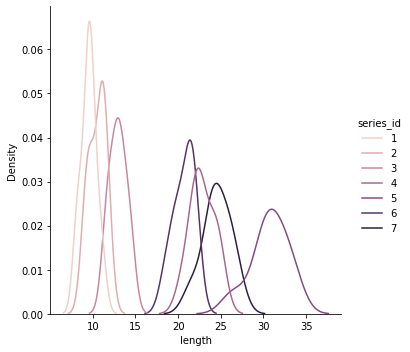

In [249]:
data = rowling_subset[rowling_subset.series_id >0]

sns.displot(x=data.length/60,hue=data.series_id,kind='kde')

HP_len_stats = data.groupby('series_id').agg({"length":['mean','std'],'title':'count'})
HP_len_stats['std percent'] = HP_len_stats[('length','std')] / HP_len_stats[('length','mean')]

print(HP_len_stats)
print("The average STDEV between languages of the same book is: {:.2f} minutes".format(HP_len_stats[("length",'std')].mean()))
print("The average Percent STDEV between languages of the same book is: {:.2f}%".format(HP_len_stats['std percent'].mean()*100))

In [296]:
# writing an aggregation function to test this.
titles_authors = titles.explode('author')


def alt_lang(row):
    length = row['length']
    length_margin = length * 0.0741
    language = row['language']
    author = row['author']

    if language != "English":
        return None
    
    alt_candidates = titles_authors[(titles_authors.author == author) & (titles_authors.language != language) & (abs(titles_authors.length - length) <= length_margin)]
    
    
    return (alt_candidates.shape[0] > 0)


#rowling_subset[0:10].apply(alt_lang, axis = 1)
#print(titles_authors[titles_authors.author == 'J.K. Rowling'][['title','language']])
#titles_authors[titles_authors.author == 'J.K. Rowling'].apply(alt_lang, axis=1)

#print(titles_authors[titles_authors.author == 'Ernest Cline'][['title','language']])
#titles_authors[titles_authors.author == 'Ernest Cline'].apply(alt_lang, axis=1)

#print(titles_authors[titles_authors.author == 'Andy Weir'][['title','language']])
#titles_authors[titles_authors.author == 'Andy Weir'].apply(alt_lang, axis=1)

print(titles_authors[titles_authors.author == 'Mark Manson'][['title','language']])
titles_authors[titles_authors.author == 'Mark Manson'].apply(alt_lang, axis=1)


                                                    title language
70065       El amor no es suficiente [Love Is Not Enough]  Spanish
70499   El sutil arte de que te importe un caraj [The ...  Spanish
75447                                Everything Is F*cked  English
123434                                  L'amore non basta  Italian
132640                                 Love Is Not Enough  English
142966                                             Models  English
245568                The Subtle Art of Not Giving a F*ck  English
245569  The Subtle Art of Not Giving a F*ck (Gujarati ...  English
245570  The Subtle Art of Not Giving a F*ck (Malayalam...  English


70065      None
70499      None
75447      True
123434     None
132640     True
142966     True
245568    False
245569     True
245570    False
dtype: object

Narration:

Authors can choose [fixed cost or to share 50% of the royalties.](https://www.acx.com/help/narrators/200484550) But for a company like Audible, it makes more sense to pay the narrators upfront, ask the author to take a lower royalty on the translated book, this way the content is evergreen and after the initial investment the content will continue to generate revenue. 

While the rates for narration services (or "Producer services") vary by the skill of the preformer, \\$200 per finished hour is considard standard. It takes about 6 hours of work to generate 1 hour of finished content. 

So for every book, we estimate the cost to produce each book. \\$200 / 60 minutes = 10/3 ~= 3.33 \\$/min

Then for Books in english, we can use the function above to estimate if they have a translation.

Then filtering the books for the lack of translation, star rating of 4 and above, and sorting by the number of ratings (ie. popularity)

In [275]:
%%time
titles_authors[0:1].apply(alt_lang,axis=1)

#1 : 52ms
#10: 451 ms
#100: 1741 ms
#1000: 21000 ms

# for the chunk below ("english, 4 stars or above, and more than 3 ratings")
#  estimated 60 minutes of run time for the filtered chunk (95585)

Wall time: 52 ms


0    False
dtype: bool

In [294]:
titles_authors['production_cost'] = titles.length * 10/3
data = titles_authors[(titles_authors['language'] == "English") & (titles_authors['star_rating'].isin(['4','4.5','5'])) & (titles_authors['count_rating'] > 3)]

data['translation_avalible'] = data.apply(alt_lang, axis=1)

data[data['translation_avalible'] == False].sort_values('count_rating', ascending = False)

<ipython-input-294-64dfccbc06db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['translation_avalible'] = data.apply(alt_lang, axis=1)


## Top Titles to Drive Conversion

Since Audible is a subscription driven company, each incremental title adds little to the chances of purchasing a subscription. In deciding to purchase a subscription, besides the lifestyle factors, most prospective users are likely to ask, is the next book I want on the platform?

Since ratings and stars are heavily skewed on the platform, and since most media retains so cross-cultural valance, we can focus on the highest proforming books to bring to a new language market. So below we examine how a new language market could be onboarded given linear translation costs and the expected number of users given different likelihoods of rating.  

In [25]:
# subsetting to 4+ stars and english books.
data = titles[(titles['star_rating'].isin(['4','4.5','5'])) & (titles.language == "English")]

# adding column for the translation cost, linear at $200 / hour or $3.3 / min.
data['production_cost'] = titles.length * 10/3


# adding possible # listeners at different likelihoods of rating, 1/10, 1/44, 1/100
# 1/43 because I have 43 audiobooks in my library and only rated 1.
data['rating_perc_10']  = titles.count_rating * 10 
data['rating_perc_44']  = titles.count_rating * 44
data['rating_perc_100'] = titles.count_rating * 100

data['count_rate'] = titles.count_rating / 

data.sort_values('count_rating', ascending = False)

<ipython-input-25-01b4e5778f84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['production_cost'] = titles.length * 10/3
<ipython-input-25-01b4e5778f84>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating_perc_10']  = titles.count_rating * 10
<ipython-input-25-01b4e5778f84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,title_url,author,language,narrator,pod_flag,price,subtitle,title,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,production_cost,rating_perc_10,rating_perc_44,rating_perc_100
245568,https://www.audible.com/pd/The-Subtle-Art-of-N...,[Mark Manson],English,[Roger Wayne],False,23.95,A Counterintuitive Approach to Living a Good Life,The Subtle Art of Not Giving a F*ck,09-13-16,317,4.5,142825.0,"[Personal Development, All Categories, Persona...",4,2016-09-13,88355,1056.666667,1428250.0,6284300.0,14282500.0
220089,https://www.audible.com/pd/The-Girl-on-the-Tra...,[Paula Hawkins],English,"[Clare Corbett, Louise Brealey, India Fisher]",False,28.00,A Novel,The Girl on the Train,01-13-15,658,4.5,137625.0,"[Psychological, Suspense, Thriller & Suspense,...",6,2015-01-13,59981,2193.333333,1376250.0,6055500.0,13762500.0
232864,https://www.audible.com/pd/The-Name-of-the-Win...,[Patrick Rothfuss],English,[Nick Podehl],False,29.99,"Kingkiller Chronicle, Book 1",The Name of the Wind,05-15-09,1675,4.5,90397.0,"[All Categories, Literary Fiction, Genre Ficti...",9,2009-05-15,15012,5583.333333,903970.0,3977468.0,9039700.0
268083,https://www.audible.com/pd/We-Are-Legion-We-Ar...,[Dennis E. Taylor],English,[Ray Porter],False,19.95,"Bobiverse, Book 1",We Are Legion (We Are Bob),09-20-16,596,4.5,88008.0,"[All Categories, Fantasy, First Contact, Hard ...",6,2016-09-20,88639,1986.666667,880080.0,3872352.0,8800800.0
104678,https://www.audible.com/pd/How-to-Win-Friends-...,[Dale Carnegie],English,[Andrew MacMillan],False,31.93,,How to Win Friends & Influence People,09-16-04,435,4.5,82266.0,"[Relationships, Personal Development, All Cate...",6,2004-09-16,2920,1450.000000,822660.0,3619704.0,8226600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240300,https://www.audible.com/pd/The-Robber-Bride-Au...,[Margaret Atwood],English,[Bernadette Dunne],False,34.95,,The Robber Bride,09-11-17,1212,4.5,2.0,[Dark Humor],1,2017-09-11,109412,4040.000000,20.0,88.0,200.0
158803,https://www.audible.com/pd/Paradise-Regained-A...,[John Milton],English,[Nadia May],False,10.49,,Paradise Regained,04-27-12,109,4.5,2.0,"[Epic, Themes & Styles, Christian Literature &...",3,2012-04-27,30388,363.333333,20.0,88.0,200.0
158844,https://www.audible.com/pd/Paralyzed-Without-F...,[Jacqueline Dunkle],English,"[Jacqueline Dunkle, Erik Fugunt, Jennifer Fugunt]",False,14.95,A Family of Their Own,Paralyzed Without Fear,05-08-20,294,4.5,2.0,[People with Disabilities],1,2020-05-08,192160,980.000000,20.0,88.0,200.0
37354,https://www.audible.com/pd/Broken-Field-Audiob...,[Jeff Hull],English,"[Lauren Ezzo, Patrick Lawlor]",False,29.99,A Novel,Broken Field,10-03-18,851,4.5,2.0,[Sports],1,2018-10-03,137518,2836.666667,20.0,88.0,200.0


In [40]:
43 * 50000 
# 2.15 million to translate into all languages
2150000 / 14.95
# 144,000 subscriber-months
# 14,000 assuming a 10 month life time

143812.70903010035

In [43]:
# to add an arbitrary filter, if we have $50,000 USD to onboard a new market we can get the following.
data.sort_values('count_rating', ascending = False)[data.sort_values('count_rating', ascending = False)['production_cost'].cumsum() < 50000]
data.sort_values('count_rating', ascending = False)[data.sort_values('count_rating', ascending = False)['production_cost'].cumsum() < 100000]

SyntaxError: invalid syntax (<ipython-input-43-3d1b3ee64dc6>, line 3)

# Category Structure <a id='cat'></a>
Audible has a variety of categories allowing the user to filter their search as desired. Interestingly the category system seems to function more like tags, with content belonging to multiple unconnected categories. Additionally, since only 1200 results are displayed in the search pane, categories containing more than 1200 titles are generally broken down into sub-categories. 

There are 1171 listed categories, 121 redirect to another page, so 1050 were scraped. 

So instead of __ we get directed to __:
- Childrens / Action-Adventure -> Literature-Fiction / Action-Adventure
- Fairy-Tales-Folk-Tales-Myths / Adaptations -> Fantasy-Magic / Fairy-Tale-Adaptations
- Biographies / Historical -> History / Historical-Biographies

#### Resources

https://www.python-graph-gallery.com/324-map-a-color-to-network-nodes \

https://networkx.org/documentation/stable/index.html

https://stackoverflow.com/questions/40092390/network-graph-is-not-visually-optimized-in-networkx

http://graphviz.org/doc/info/attrs.html#d:layout

https://graphviz.readthedocs.io/en/stable/manual.html

https://www.graphviz.org/pdf/dotguide.pdf

https://graphviz.org/doc/info/attrs.html

https://pygraphviz.github.io/documentation/stable/pygraphviz.pdf


# Category EDA <a id='cat_eda'></a>

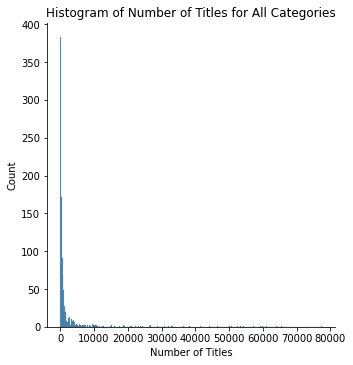

In [40]:
data = cat_data['category_numb_title']
plot = sns.displot(data)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles for All Categories")

#plt.show()
plt.savefig("./graphics/hist_cats.png", bbox_inches = 'tight')

In [34]:
big_bois = cat_data[cat_data['parent_category']== 'Audible'].filter(items = ['category_name','category_numb_title'])
big_bois.columns = ['Top Level Category Name','Number of Titles']
big_bois.set_index('Top Level Category Name')

,Number of Titles
Top Level Category Name,
Travel & Tourism,8631
Teen,18661
Sports & Outdoors,22415
Science Fiction & Fantasy,61202
Science & Engineering,17495
Romance,63904
Religion & Spirituality,55302
"Relationships, Parenting & Personal Development",58980
Politics & Social Sciences,59844


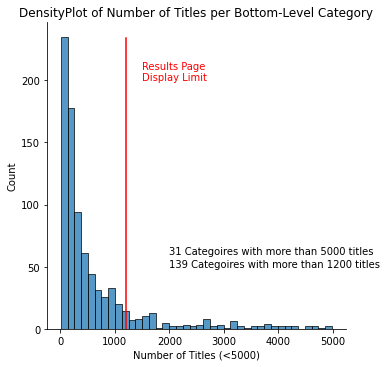

In [17]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']
plot = sns.displot(data2)

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=200, s= "Results Page \nDisplay Limit", color = 'r')

plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


#plt.show()
plt.savefig("./graphics/hist_leafs.png", bbox_inches = 'tight')

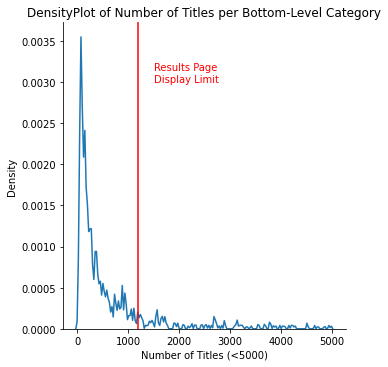

In [29]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']

plot = sns.displot(data2, kind = 'kde', bw_adjust = 0.05)

plt.axvline(1200, 0, 1, color = 'r')
plt.text(x=1500, y=0.003, s= "Results Page \nDisplay Limit", color = 'r')

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')

#plt.show()
plt.savefig("./graphics/density_leafs.png", bbox_inches = 'tight')

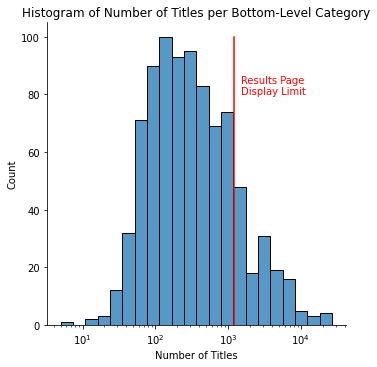

In [204]:
data2 = cat_data[cat_data['leaf_flag']==True]['category_numb_title']
plot = sns.displot(data2,log_scale = True)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=80, s= "Results Page \nDisplay Limit", color = 'r')

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


plt.show()
#plt.savefig("./graphics/hist_log_leafs.png", bbox_inches = 'tight')

In [24]:
large_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >5000)]['category_numb_title']
print("There are {} leaf categories with more than 5000 titles.".format(len(large_leafs)))

display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
print("There are {} leaf categories with more than 1200 titles, the display limit.".format(len(display_limit_leafs)))

There are 31 leaf categories with more than 5000 titles.
There are 139 leaf categories with more than 1200 titles, the display limit.


In [5]:
cat_data[(cat_data['leaf_flag']==True)].shape

(869, 7)

In [41]:
display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
string = "{} is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories."
print(string.format(sum(display_limit_leafs)))

583153 is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories.


This offers the oppurtunity to expand these leaf-categories into sub-categories which could provide the user more choice. Significantly the top level category of **Erotica** only has two sub-categories **Literature & Fiction** and **Sexual Instruction** which is suprising considering Audible has a feature [specifically targeted](https://qz.com/1116293/audible-is-launching-a-feature-that-lets-you-jump-right-to-the-most-erotic-part-of-an-audiobook/) at this category of audiobooks. My best alternative hypothesis is most **Erotica/Literature & Fiction** titles are also represented in the **Romance** section which is broken down into many sub-categories.  

Personal Success might offer an easy split "Managing your vanity" and "How does my hair look?"

In [54]:
# Top and bottom categories
data2      = cat_data[cat_data['leaf_flag']==True]
top_       = data2.sort_values('category_numb_title',ascending = False).head(5)
bottom_    = data2.sort_values('category_numb_title',ascending = False).tail(5)
top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title'])
top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles']

#Get URL
#top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title', 'self_url'])
#top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles', 'Category URL']
#print(top_bottom.to_string())

top_bottom

,Parent Category,Category Name,Number of Titles
174,Personal Development,Personal Success,26798
823,Thriller & Suspense,Suspense,26385
597,Erotica,Literature & Fiction,23118
251,Romance,Contemporary,20868
925,Management & Leadership,Leadership,16045
857,Biographies,Adventurers & Explorers,18
396,"Health, Lifestyle & Relationships",Sexuality & Sexual Health,17
426,Historical Fiction,Action & Adventure,16
401,Science Fiction,Anthologies & Short Stories,13
587,Language Learning,Latin,5


426 : Teen / Lit & Fic / Historical Fiction / A & A

401 : Teen / Scifi & Fantasy / SciFi / Anthology...



# Network Visualization <a id='network'></a>

In [96]:
# adding a false entry to make assignments easier. 
cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

#Creating new column for better node visualization
cat_data['log_numb_title'] = np.log(cat_data['category_numb_title'])
cat_data['scaled_numb_title'] = np.interp(cat_data.category_numb_title,
                                         (cat_data.category_numb_title.min(),
                                         cat_data.category_numb_title.max()),
                                         (1,300))
cat_data['scaled_log_numb_title'] = np.interp(cat_data.log_numb_title,
                                         (cat_data.log_numb_title.min(),
                                         cat_data.log_numb_title.max()),
                                         (1,300))

ValueError: Received invalid argument(s): layout

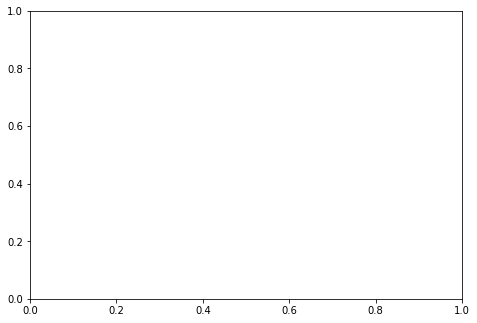

In [3]:
graph = nx.from_pandas_edgelist(cat_data, 'parent_url','self_url', create_using=nx.DiGraph())

node_info = cat_data.set_index('self_url').reindex(graph.nodes())
#node_dic  = node_info.filter(['category_name']).T.to_dict('dict')

nx.draw(graph, 
        with_labels = False,
        labels      = node_info['category_name'],
        arrows      = True,
        #node_color  = node_info['category_numb_title'],
        node_size   = node_info['category_numb_title'], # pretty good
        #node_size   = node_info['log_numb_title'], # very small points, 
        #node_size   = node_info['scaled_numb_title'], # very small points
        #node_size   = node_info['scaled_log_numb_title'], #visable points, too small
        #pos         = nx.fruchterman_reingold_layout(graph) #doesnt seem to work
        layout       = nx.kamada_kawai_layout(graph) #doesnt quite work
       )
#plt.rcParams['figure.figsize'] = (50,50)
plt.title("Audible Categories")
#plt.show()
#plt.savefig("category_network.png")




In [6]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

ImportError: cannot import name '_graphviz' from partially initialized module 'pygraphviz' (most likely due to a circular import) (c:\users\james\dropbox\nydsa\projects\web scraping\finding_the_tree_in_the_forest\local-env\lib\site-packages\pygraphviz\__init__.py)

In [5]:
import graphviz
#import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

edges = list(zip(cat_data.parent_url, cat_data.self_url))


labels = dict(zip(cat_data.self_url,cat_data.category_name))


G = nx.DiGraph() # Create an empty Graph

for k,v in labels.items():
    G.add_node(k,label=v)
G.add_edges_from(edges)

A = to_agraph(G)

A.draw('hier_categories.png', prog='dot') # Hierarchical
A.draw('circular_categories.png', prog='neato') #circular

ImportError: requires pygraphviz http://pygraphviz.github.io/

In [ ]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

graph = nx.DiGraph()
graph.add_nodes_from()
graph.add_edges_from()
